In [1]:
import pandas as pd
import numpy as np
import os
import re   
import time
import math
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from linearmodels.panel import PanelOLS, RandomEffects
from linearmodels.panel import compare
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
from scipy import stats

from loader import *
from plot import *
from analysis import *
from preprocessing import *

# 1. 데이터 로드 및 준비

## 1.1. 데이터 로드

In [2]:
sas_files = set_dataset_path()
data_dict = join_sas_by_code(sas_files)

# 데이터프레임들을 딕셔너리로 통합
all_dfs = {
    'cd': concat_by_code(data_dict, 'cd'),
    'ind': concat_by_code(data_dict, 'ind'),
    'hh': concat_by_code(data_dict, 'hh'),
    'er': concat_by_code(data_dict, 'er'),
    'in': concat_by_code(data_dict, 'in'),
    'ou': concat_by_code(data_dict, 'ou'),
    'appen': concat_by_code(data_dict, 'appen'),
}

cd코드 로드 완료! 

ind코드 로드 완료! 

hh코드 로드 완료! 

er코드 로드 완료! 

in코드 로드 완료! 

ou코드 로드 완료! 

appen코드 로드 완료! 



## 1.2. 데이터 범위 필터링

- 당뇨병 진단 받은 환자 수로 필터링 = 총 1,865명.

### 1.2.1. CD (만성질환)

In [3]:
# STEP 1: 행 필터링
filtered_df_cd, unique_hhid, unique_pid  = filter_cd(all_dfs['cd'])
filtered_df_cd.head()

# filtered_df_cd.info()
# filtered_df_cd.describe()
# check_columns(filtered_df_cd)
# numeric_cols_cd, categorical_cols_cd = separate_columns(filtered_df_cd)

CD3_2(의사진단여부) 컬럼 내 unique 값 = [1.]
CDNUM(만성질환번호) 컬럼 내 unique 값 = [2.]
필터링 된 데이터셋 내의 unique 가구 ID의 수 = 1672
필터링 된 데이터셋 내의 unique 가구원 ID의 수 = 1865
필터링 이전 대비 이후 환자 데이터셋 크기 비율 = 0.0101
필터링 이전 대비 이후 환자 ID 비율 = 0.0917


,HHIDWON,M1,M2,HHID,PID,PIDWON,HPID,CDNUM,cd1_1,CD2,...,CD5,CD6,CD9,CD10,CD11,CD12_0,CD12,CD19,YEAR,CD1_1
0,10004.0,11.0,1.0,100040111.0,2.0,1000402.0,1.000401e+10,2.0,b'E11',1.0,...,2.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2017,NaN
1,10006.0,11.0,1.0,100060111.0,1.0,1000601.0,1.000601e+10,2.0,b'E11',1.0,...,1.0,-1.0,1.0,-1.0,2.0,-1.0,-1.0,2.0,2017,NaN
2,10006.0,11.0,1.0,100060111.0,2.0,1000602.0,1.000601e+10,2.0,b'E11',1.0,...,1.0,-1.0,1.0,-1.0,2.0,-1.0,-1.0,2.0,2017,NaN
3,10030.0,11.0,1.0,100300111.0,2.0,1003002.0,1.003001e+10,2.0,b'E11',3.0,...,1.0,-1.0,1.0,-1.0,2.0,-1.0,-1.0,2.0,2017,NaN
4,10033.0,11.0,1.0,100330111.0,1.0,1003301.0,1.003301e+10,2.0,b'E11',1.0,...,1.0,-1.0,1.0,-1.0,2.0,-1.0,-1.0,2.0,2017,NaN


In [4]:
# STEP 2: 컬럼 필터링
filtered_df_cd = filtered_df_cd.drop(['CDNUM', 'M1', 'M2','cd1_1', 'CD1_1', 'CD12_0', 'CD3_2', 'CD12', 'CD1_1', 'CD2'], axis = 1)
# filtered_df_cd.head()


- CD6 = 미복용이유 = 자발적(0) / 비자발적(1) / 경제적 이유 (2)인지 3가지로 변환.
    - 1 = 약 먹을만큼 심각하지 않아서
    - 2 = 효과가 별로 없어서
    - 3 = 약을 먹어서 부작용이 생기거나 몸에 해로울까봐
    - 4 = 경제적 이유로 (약값 비싸서)
    - 5 = 기타
    - 6 = 약 이외의 치료 중 (혈액투석, 물리치료 등)
    - 7 = 의사가 약을 처방하지 않음
    - -1 = 해당사항 없음
    - -9 = 모름 / 무응답

- CD9 = 정해진 복용법대로 복용하는지?
    - 1 = 예 / 2 = 아니요 / -9, -1 = 모름, 해당사항 없음

- CD11 = 복용약으로 인한 부작용 발생 여부
    - 1 = 예 / 2 = 아니오 / -1, -9 = 모름, 해당사항 없음

- CD19 = 약물 만족도: 만족들을 2, 보통을 1, 불만족들을 0으로 변환
    - 1 = 매우 만족 / 2 = 만족 / 3 = 보통 / 4 = 불만족
    - 5 = 매우 불만족 / -1, -9 = 모름, 해당사항 없음


In [5]:
# STEP 3: 컬럼 인코딩 및 리네이밍

'''
컬럼 필터링
CD3_1 = 최초 진단 연도
CD4 = 해당 질환으로 인한 의료 이용 여부
CD5 = 의약품복용 여부
CD6 = 약물 미복용 이유
CD9 = 복약순응 = 정해진 복용법대로 복용하는지
CD11 = 복용약으로 부작용 발생 여부
CD4 = 해당 질환으로 인한 의료 이용 여부
CD19 = 약물 만족도
'''
columns_cd = id_columns + ['CD3_1','CD4', 'CD5', 'CD6', 'CD9', 'CD11', 'CD19', 'YEAR']
df_cd = filtered_df_cd[columns_cd]

final_df_cd = df_cd.copy()

cd_4_map = {1: 1, 2:0, -9: -1}
cd_5_map = {1: 1, 2:0, -9: -1}
cd_6_map = {-1: "unknown", -9: 'unknown', 1:'voluntary', 1: 'voluntary', 2: 'voluntary', 3: 'involuntary',
            4: 'involuntary', 5: 'voluntary', 6: 'involuntary', 7:'involuntary'}
cd_9_map = {1: 1, 2:0, -9: -1, -1: -1}
cd_11_map = {1: 1, 2:0, -9: -1, -1: -1}
cd_19_map = {1: 'satisfied', 2: 'satisfied', 3: 'dissatisfied', 4: 'dissatisfied', 5:'dissatisfied', -1: 'unknown', -9: 'unknown'}

map_cols = ['CD4', 'CD5', 'CD6', 'CD9', 'CD11', 'CD19']
mappers = [cd_4_map, cd_5_map, cd_6_map, cd_9_map, cd_11_map, cd_19_map]

rename_cols_code = ['CD3_1', 'CD4', 'CD5', 'CD6', 'CD9', 'CD11', 'CD19']
rename_cols_text = ['num_years_since_diagnosis', 'visited_facility_this_year', 'intake_medication_this_year', 'reason_no_intake', 'followed_prescription', 'had_medication_side_effects', 'medication_satisfaction']

mapping_dict_cd = {col: mapper for col, mapper in zip(map_cols, mappers)}
rename_dict_cd = {col: rename_col for col, rename_col in zip(rename_cols_code, rename_cols_text)}

final_df_cd = map_df(final_df_cd, mapping_dict_cd)
final_df_cd = rename_df(final_df_cd, rename_dict_cd)

final_df_cd.head()

,HHIDWON,PIDWON,num_years_since_diagnosis,visited_facility_this_year,intake_medication_this_year,reason_no_intake,followed_prescription,had_medication_side_effects,medication_satisfaction,YEAR
0,10004.0,1000402.0,2016.0,0,0,involuntary,-1,-1,unknown,2017
1,10006.0,1000601.0,2011.0,1,1,unknown,1,0,satisfied,2017
2,10006.0,1000602.0,2013.0,1,1,unknown,1,0,satisfied,2017
3,10030.0,1003002.0,2017.0,1,1,unknown,1,0,satisfied,2017
4,10033.0,1003301.0,2012.0,1,1,unknown,1,0,satisfied,2017


In [6]:
# STEP 4: 특정 컬럼 별 세부 처리
final_df_cd = calculate_num_years(final_df_cd, ['num_years_since_diagnosis'])

In [7]:
# STEP 5: 원핫 인코딩
onehot_columns = final_df_cd.select_dtypes(include=['category']).columns
# print(onehot_columns)
final_df_cd = onehot_df(final_df_cd, onehot_columns)
# print(final_df_cd.select_dtypes(include=['category']).columns)
# final_df_cd.head()

In [8]:
# STEP 6: 모든 컬럼을 int 형으로 변환 (object → int, 예외 발생 시 처리)
final_df_cd = convert_into_int(final_df_cd)

# STEP 7: YEAR 컬럼을 가장 오른쪽으로 이동
final_df_cd = move_year_column(final_df_cd)   

print(final_df_cd.columns)
final_df_cd.head()

Index(['HHIDWON', 'PIDWON', 'num_years_since_diagnosis',
       'visited_facility_this_year', 'intake_medication_this_year',
       'followed_prescription', 'had_medication_side_effects',
       'reason_no_intake_involuntary', 'reason_no_intake_unknown',
       'reason_no_intake_voluntary', 'medication_satisfaction_dissatisfied',
       'medication_satisfaction_satisfied', 'medication_satisfaction_unknown',
       'YEAR'],
      dtype='object')


,HHIDWON,PIDWON,num_years_since_diagnosis,visited_facility_this_year,intake_medication_this_year,followed_prescription,had_medication_side_effects,reason_no_intake_involuntary,reason_no_intake_unknown,reason_no_intake_voluntary,medication_satisfaction_dissatisfied,medication_satisfaction_satisfied,medication_satisfaction_unknown,YEAR
0,10004,1000402,1,0,0,-1,-1,1,0,0,0,0,1,2017
1,10006,1000601,6,1,1,1,0,0,1,0,0,1,0,2017
2,10006,1000602,4,1,1,1,0,0,1,0,0,1,0,2017
3,10030,1003002,0,1,1,1,0,0,1,0,0,1,0,2017
4,10033,1003301,5,1,1,1,0,0,1,0,0,1,0,2017


#### 1.2.2. IND (가구원정보)

- 핵심 변수
  - A9
    - 가구원 주 사망 원인
    - 유효 / - 1 = 해당사항 없음 / -9 = 모름, 무응답
  - A9_4 (KCD6)
    - 주된 사망 원인 코드
    - 유효 / - 1 = 해당사항 없음 / -9 = 모름, 무응답
  - I_MEDICAL_EXP1
    - 개인 지출 의료비
  - TOTAL_Q5
    - 총 가구소득 5분위

In [9]:
# STEP 1: 행 필터링
filtered_df_ind = filter_rest(all_dfs['ind'], unique_hhid, unique_pid)
print(filtered_df_ind.columns)
filtered_df_ind.head()

필터링 이전 대비 이후 환자 데이터셋 크기 비율 = 0.0955
필터링 이전 대비 이후 환자 ID 비율 = 0.0917
Index(['HHIDWON', 'M1', 'M2', 'HHID', 'PID', 'PIDWON', 'HPID', 'I_WGC_08',
       'I_WGC_TOT', 'WGL_08', 'WGL_TOT', 'WGL_M_08', 'WGL_M_TOT', 'A2', 'A2_0',
       'A2_1', 'A2_2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9_4', 'A10',
       'A11', 'A12', 'C2', 'C3', 'C4_0', 'C5', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C13_1', 'C13_2', 'C14', 'C15', 'C16_1', 'C17', 'C18',
       'C24', 'C25', 'C26', 'C27', 'C28', 'C32_0', 'C32', 'C33', 'C34', 'C35',
       'C36', 'C37', 'C37_1', 'C41', 'C42', 'C43', 'C44', 'C45', 'PR1', 'PR2',
       'PR3', 'PR4', 'PR5', 'PR6', 'PR6_1', 'PR12', 'PR13', 'PR14', 'PR15',
       'PR16', 'PR17', 'PR18', 'PR19', 'PR20', 'PR19_1', 'PR20_1', 'PR19_2',
       'PR20_2', 'I_MEDICALEXP1', 'I_MEDICALEXP2', 'TOTAL_Q5_08',
       'TOTAL_Q10_08', 'W_TOTAL_Q5_08', 'W_TOTAL_Q10_08', 'TOTAL_Q5_TOT',
       'TOTAL_Q10_TOT', 'W_TOTAL_Q5_TOT', 'W_TOTAL_Q10_TOT', 'YEAR', 'C12_1',
       'C12_2'],
   

,HHIDWON,M1,M2,HHID,PID,PIDWON,HPID,I_WGC_08,I_WGC_TOT,WGL_08,...,TOTAL_Q10_08,W_TOTAL_Q5_08,W_TOTAL_Q10_08,TOTAL_Q5_TOT,TOTAL_Q10_TOT,W_TOTAL_Q5_TOT,W_TOTAL_Q10_TOT,YEAR,C12_1,C12_2
1,10004.0,11.0,1.0,100040111.0,2.0,1000402.0,1.000401e+10,5116.224912,3768.792843,0.000000,...,4.0,2.0,4.0,2.0,4.0,2.0,4.0,2017,NaN,NaN
4,10006.0,11.0,1.0,100060111.0,1.0,1000601.0,1.000601e+10,6037.822879,4451.959464,6365.821586,...,8.0,4.0,8.0,4.0,8.0,4.0,8.0,2017,NaN,NaN
5,10006.0,11.0,1.0,100060111.0,2.0,1000602.0,1.000601e+10,7605.154585,5605.618816,8193.433264,...,8.0,4.0,8.0,4.0,8.0,4.0,8.0,2017,NaN,NaN
24,10030.0,11.0,1.0,100300111.0,2.0,1003002.0,1.003001e+10,2493.356339,1837.524298,2717.281960,...,3.0,1.0,2.0,2.0,3.0,1.0,2.0,2017,NaN,NaN
29,10033.0,11.0,1.0,100330111.0,1.0,1003301.0,1.003301e+10,6346.984168,4680.089119,6708.793160,...,9.0,4.0,8.0,5.0,9.0,4.0,8.0,2017,NaN,NaN


컬럼 필터링

- C8 = 교육수준
- C4_0 = 출생연도
- C12_1 = 의료급여개시 연도
- C15 = 국민연금가입
    - 1 = 납부중 / 2 = 납부안함 / 3 = 수령중 / -9 = 해당사항 없음
- C33 = 종사상 지위: 정규직은 1, 나머지는 0으로 변환.
    - 0 = 정규직 / 1 = 상용직 / 2 = 임시직 / 3 = 일용직 /
    - 4 = 자활근로, 공공근로, 노인 일자리 / 5 = 자영업자 / -6, -1 = 해당사항 없음
- C24 = 경제활동유무: 0 = NO, 1 = YES, 

- C35 = 근무지속가능여부: 1 = 예 / 0 = 아니오
- C14 = 장애등급: -1 = 해당사항 없음 / 나머지 양수 = 장애 등급
- C26 = 일자리유형: 1 = 임금근로자 / 2 = 고용주, 자영업자 / 3 = 무급가족종사자 / -1, -6 = 해당사항 없음
- C18 = 민간연금 / 종신보험 가입: 1 = 개인연금만 / 2 = 종신보험만 / 3 = 둘다 가입 / 4 = 둘다 미가입
- C16_1 = 산재보험 가입: 1 = 납부중 / 2 = 납부안함 / 3 = 수령중 / -1, -9 = 해당사항 없음
- C7 = 혼인상태: 1 = 혼인중 / 2 = 별거 / 3 = 사별 또는 실종 / 4 = 이혼 / 5 = 없음
- C25 = 비경제활동이유: 1 = 자발적 / 0 = 자발적으로 인코딩하여 변환
- C11 = 의료보장형태: standard / public / special / excluded로 변환.

In [10]:
# STEP 2: 컬럼 필터링
columns_ind = id_columns + ['C8','C4_0', 'C12_1', 'C15', 'C33', 'C24', 'C35', 'C14',
                            'C26','C18', 'C16_1', 'C7', 'C25', 'C11', 'I_MEDICALEXP1','YEAR']
df_ind = filtered_df_ind[columns_ind]

In [11]:
final_df_ind = df_ind.copy()

In [12]:
# STEP 3: 컬럼 인코딩 및 리네이밍
c_15_map = {1: 'paying', 2: 'unpaying', 3: 'receiving', -9: 'unknown'}
c_33_map = {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, -1: -1, -6: -1}
c_24_map = {1: 1, 2: 0, -1: -1, -6: -1}
c_35_map = {1: 1, 2: 0, -1: -1, -6: -1, -9: -1}
# c_14_map = {-1: 0, 1: 1, 2: 1,  3: 1, 4: 1, 5:1, 6:1} # 장애 등급
c_26_map = {3:'family_unpaid', 1:'employee', 2:'employer', -1: 'unknown', -6: 'unknown'}
c_18_map = {1: 'pension', 2: 'whole_insurance', 3: 'pension_and_insurance', 4: 'non_registered'}
c_16_map = {1: 'paying', 2: 'unpaying', 3: 'receiving', -9: 'unknown'}
c_7_map = {1: 1, 2: 0, 3: 0, 4:0, 5:0}
c_25_map = {
    1: 'voluntary', 3: 'voluntary', 4: 'voluntary', 12: 'voluntary', 13: 'voluntary', 14: 'voluntary', 11: 'voluntary',  # 자발적
    2: 'involuntary', 5: 'involuntary', 6: 'involuntary', 7: 'involuntary', 8: 'involuntary', 9: 'involuntary', 10: 'involuntary',      # 비자발적
    -1: 'unknown', -6: 'unknown'
}
c_11_map = {
    1: 'standard', 2: 'standard', 3: 'standard',
    4: 'public', 5: 'public', 10: 'public',
    6: 'special', 7: 'special', 8: 'excluded', 9: 'excluded'}

map_cols = ['C15', 'C33', 'C24', 'C35', 'C26', 'C18', 'C7', 'C25', 'C11']
mappers = [c_15_map, c_33_map, c_24_map, c_35_map, c_26_map, c_18_map, c_7_map, c_25_map, c_11_map]

rename_cols_code = ['C16_1', 'C4_0', 'C8', 'C12_1', 'C15', 'C33', 'C24', 'C35', 'C14', 'C26', 'C18', 'C7', 'C25', 'C11', 'I_MEDICALEXP1']
rename_cols_text = ['worker_comp_insurance', 'age', 'education_level', 'num_years_since_med_pension', 'pension_receipt_status', 'is_full_timer', 'employed', 'work_availability', 'has_disability', 'employment_type', 'private',  'married', 'reason_no_work', 'type_medical_support', 'medical_expense']

mapping_dict_ind = {col: mapper for col, mapper in zip(map_cols, mappers)}
rename_dict_ind = {col: rename_col for col, rename_col in zip(rename_cols_code, rename_cols_text)}
# rename_dict_ind

final_df_ind = map_df(final_df_ind, mapping_dict_ind)
final_df_ind = rename_df(final_df_ind, rename_dict_ind)
# final_df_ind.head()

In [13]:
# STEP 4: 특정 컬럼 별 세부 처리
final_df_ind['education_level'] = (final_df_ind['education_level'] // 10).astype('int') # 0 = 미취학, 무학 / 1 = 초졸 / 2 = 중졸 / 3 = 고졸 / 4 = 대졸 / 5 = 대학원 졸
final_df_ind['medical_expense'] = final_df_ind['medical_expense'].astype('int')
final_df_ind['has_disability'] = final_df_ind['has_disability'].apply(lambda x: 0 if x < 0 else x) # 장애 없을 경우 = 0, 있을 경우 장애 등급
final_df_ind['worker_comp_insurance'] = final_df_ind['worker_comp_insurance'].apply(lambda x: -1 if x < 0 else x)
final_df_ind = calculate_num_years(final_df_ind, ['age', 'num_years_since_med_pension'])
final_df_ind['age'] = final_df_ind['age'].apply(lambda x: -1 if x < 0 else x)
final_df_ind['num_years_since_med_pension'] = final_df_ind['num_years_since_med_pension'].apply(lambda x: -1 if x < 0 else x)
# final_df_ind.head()

In [14]:
# STEP 5: 원핫 인코딩
onehot_columns = final_df_ind.select_dtypes(include=['category']).columns
final_df_ind = onehot_df(final_df_ind, onehot_columns)
# final_df_ind.head()

In [15]:
# STEP 6: 모든 컬럼을 int 형으로 변환 (object → int, 예외 발생 시 처리)
final_df_ind = convert_into_int(final_df_ind)

# STEP 7: YEAR 컬럼을 가장 오른쪽으로 이동
final_df_ind = move_year_column(final_df_ind)   

print(final_df_ind.columns)
final_df_ind.head()

Index(['HHIDWON', 'PIDWON', 'education_level', 'age',
       'num_years_since_med_pension', 'is_full_timer', 'employed',
       'work_availability', 'has_disability', 'worker_comp_insurance',
       'married', 'medical_expense', 'pension_receipt_status_paying',
       'pension_receipt_status_receiving', 'pension_receipt_status_unknown',
       'pension_receipt_status_unpaying', 'employment_type_employee',
       'employment_type_employer', 'employment_type_family_unpaid',
       'employment_type_unknown', 'private_non_registered', 'private_pension',
       'private_pension_and_insurance', 'private_whole_insurance',
       'reason_no_work_involuntary', 'reason_no_work_unknown',
       'reason_no_work_voluntary', 'type_medical_support_public',
       'type_medical_support_special', 'type_medical_support_standard',
       'YEAR'],
      dtype='object')


,HHIDWON,PIDWON,education_level,age,num_years_since_med_pension,is_full_timer,employed,work_availability,has_disability,worker_comp_insurance,...,private_pension,private_pension_and_insurance,private_whole_insurance,reason_no_work_involuntary,reason_no_work_unknown,reason_no_work_voluntary,type_medical_support_public,type_medical_support_special,type_medical_support_standard,YEAR
1,10004,1000402,5,64,-1,0,1,1,0,2,...,0,0,0,0,1,0,0,0,1,2017
4,10006,1000601,4,62,-1,-1,1,-1,0,2,...,0,0,0,0,1,0,0,0,1,2017
5,10006,1000602,1,61,-1,-1,1,-1,0,2,...,0,0,0,0,1,0,0,0,1,2017
24,10030,1003002,2,79,-1,-1,1,-1,0,2,...,0,0,0,0,1,0,0,0,1,2017
29,10033,1003301,3,56,-1,0,1,0,0,1,...,0,0,1,0,1,0,0,0,1,2017


### 1.2.3. HH (가구정보)

- 핵심 변수
  - H_MEDICAL_EXP1 (원 단위)
    - 가구 의료비
      - 응급의료비 + 입원의료비 + 외래의료비 + 응급처방약값 + 입원처방약값 + 외래처방약값
    - 평균 170만 5339원
  - TOTAL (만원 단위)
    - 연간 총 가구소득 = 근로소득 + 자산소득
    - 평균 4230만 9680원
    
  - 아래 변수들은 데이터 정의서에서 발견된 중요한 변수이지만, 본 데이터에서는 부재하므로, 사용 불가.
    - CD5
      - 의약폼 복용 여부
        - 1 = 예 / 2 = 아니오 / -1 = 해당사항 없음 / -6 = 설문대상 아님 / -9 = 모름 & 무응답
    - CD12_0
      - 월평균 약값
        - 유효(원) / 0 = 0원 / 5 = 병원소에서 약 받음 / -1 = 해당사항 없음 / -9 = 모름 /무응답

    - CD16_1
      - 연 병원 방문 횟수
        - 유효 / -1 = 해당사항 없음 / -6 = 이전질환 응답오류 / -9 = 모름 / 무응답
    - CD18
      - 주요 치료 기관 형태
        - 1 = 종합병원, 대학병원 / 2 = 병원 / 3 = 의원 / 4 = 보건소 , 보건의료원 / 5 = 한방병의원 / 6 = 치과병의원 / 7 = 기타 / -1 = 해당사항 없음 / -6 = 설문대상 아님 / -9 = 모름 /무응답


In [16]:
# 주의: 가구정보 테이블에는 개인 식별 고유 코드 미존재. 가구 코드만 존재.
print('PIDWON' in all_dfs['hh'].columns)
print('HHIDWON' in all_dfs['hh'].columns)

False
True


In [17]:
# STEP 1: 행 필터링
filtered_df_hh= filter_hh(all_dfs['hh'], unique_hhid)
print(filtered_df_hh.columns)
filtered_df_hh.head()

필터링 된 데이터셋 내의 unique 가구 ID의 수 = 1672
필터링 이전 대비 이후 환자 데이터셋 크기 비율 = 0.2622
Index(['HHIDWON', 'M1', 'M2', 'HHID', 'H_WGC_08', 'H_WGC_TOT', 'M6', 'M7',
       'M8', 'P', 'P2', 'B1', 'B2', 'B3', 'B4_0', 'B41', 'B42', 'B43', 'B44',
       'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B13', 'TOT_H', 'INC1',
       'INC2', 'INC3', 'INC4', 'INC5', 'INC6', 'INC7', 'TOT_INC', 'TOTAL',
       'TOTAL_Q5_08', 'TOTAL_Q10_08', 'W_TOTAL_Q5_08', 'W_TOTAL_Q10_08',
       'TOTAL_Q5_TOT', 'TOTAL_Q10_TOT', 'W_TOTAL_Q5_TOT', 'W_TOTAL_Q10_TOT',
       'SAV', 'LIV', 'LIV2', 'LIV3', 'H1', 'H2', 'H3', 'H3_1', 'H4_1', 'H5',
       'H6_21', 'H6_22', 'H6_23', 'H6_24', 'H6_25', 'H78', 'H11', 'H12',
       'H_MEDICALEXP1', 'H_MEDICALEXP2', 'H_MEDICALEXP3', 'H_MEDICALEXP4',
       'H_MEDICALEXP5', 'YEAR', 'h_wgc_08', 'B4', 'B4_1', 'total_q5_tot',
       'total_q10_tot', 'w_total_q5_tot', 'w_total_q10_tot', 'B12', 'H4',
       'H6_11', 'H6_12', 'H6_13', 'H6_14', 'H6_15', 'H10'],
      dtype='object')


,HHIDWON,M1,M2,HHID,H_WGC_08,H_WGC_TOT,M6,M7,M8,P,...,w_total_q5_tot,w_total_q10_tot,B12,H4,H6_11,H6_12,H6_13,H6_14,H6_15,H10
1,10004.0,11.0,1.0,100040111.0,5173.019804,3933.451643,2018.0,3.0,5.0,41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10006.0,11.0,1.0,100060111.0,7510.411313,5191.513271,2018.0,3.0,7.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,10030.0,11.0,1.0,100300111.0,3291.609614,2137.657438,2018.0,2.0,12.0,41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,10033.0,11.0,1.0,100330111.0,6230.191427,4665.427541,2018.0,5.0,16.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,10036.0,11.0,1.0,100360111.0,7367.230483,5602.853523,2018.0,2.0,15.0,41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# numeric_cols_hh, categorical_cols_hh = separate_columns(filtered_df_hh)

In [19]:
'''
B1 = 총 가구원 수
B6 = 주거형태: 1 = 단독, 2 = 다세대, 3 = 연립, 4 = 일반 (임대) 아파트, 5 = 영구임대아파트, 6 = 영업용건물, 7 = 오피스텔, 8 = 기타
B7 = 주택소유여부: 1 = 자가, 2 = 전세, 3 = 월세, 4 = 무상, 5 = 기타 (부모 명의 거주)
B13 = 주거위치: 1 = 지상층, 2 = 반지하층, 3 = 지하층, 4 = 옥탑
TOT_H = 가구 총 근로소득 (만원)
TOT_INC = 총 자산소득 (만원)
TOTAL = TOT_H + TOT_INC (만원)
H_MEDICALEXP1 = 가구지출 의료비 (원)
'''
# STEP 2: 컬럼 필터링
columns_hh =  ['HHIDWON', 'B1', 'B6', 'B7', 'B13', 'TOT_H', 'TOT_INC', 'TOTAL', 'H_MEDICALEXP1', 'YEAR']
df_hh = filtered_df_hh[columns_hh]
df_hh.head()

,HHIDWON,B1,B6,B7,B13,TOT_H,TOT_INC,TOTAL,H_MEDICALEXP1,YEAR
1,10004.0,3.0,1.0,4.0,1.0,3700.0,314.0,4014.0,1997380.0,2018
2,10006.0,3.0,4.0,1.0,1.0,2760.0,1308.0,4068.0,2990460.0,2018
11,10030.0,2.0,1.0,1.0,1.0,200.0,1414.0,1614.0,878110.0,2018
14,10033.0,4.0,5.0,2.0,1.0,10200.0,2580.0,12780.0,2197215.0,2018
16,10036.0,3.0,1.0,1.0,1.0,0.0,1494.0,1494.0,2733165.0,2018


In [20]:
# TOTAL = TOT_H + TOT_INC 으로 추정.
all_dfs['hh'][all_dfs['hh']['HHIDWON'] == 32519.0][['HHIDWON', 'HHID', 'H_MEDICALEXP1', 'TOT_H','TOT_INC', 'TOTAL', 'SAV','LIV','YEAR']]

,HHIDWON,HHID,H_MEDICALEXP1,TOT_H,TOT_INC,TOTAL,SAV,LIV,YEAR
6374,32519.0,325190511.0,736690.0,4000.0,720.0,4720.0,200.0,167.0,2018
6375,32519.0,325191011.0,0.0,5500.0,0.0,5500.0,50.0,94.0,2018
12979,32519.0,325190511.0,412120.0,6800.0,1121.0,7921.0,330.0,250.0,2015
19389,32519.0,325190511.0,126790.0,2550.0,1724.0,4274.0,100.0,240.0,2017
19390,32519.0,325191011.0,0.0,4500.0,0.0,4500.0,80.0,155.0,2017
26248,32519.0,325190511.0,303700.0,3800.0,3.0,3803.0,100.0,200.0,2014
32689,32519.0,325190511.0,213400.0,5800.0,0.0,5800.0,50.0,300.0,2016


In [21]:
final_df_hh = df_hh.copy()
final_df_hh.head()

,HHIDWON,B1,B6,B7,B13,TOT_H,TOT_INC,TOTAL,H_MEDICALEXP1,YEAR
1,10004.0,3.0,1.0,4.0,1.0,3700.0,314.0,4014.0,1997380.0,2018
2,10006.0,3.0,4.0,1.0,1.0,2760.0,1308.0,4068.0,2990460.0,2018
11,10030.0,2.0,1.0,1.0,1.0,200.0,1414.0,1614.0,878110.0,2018
14,10033.0,4.0,5.0,2.0,1.0,10200.0,2580.0,12780.0,2197215.0,2018
16,10036.0,3.0,1.0,1.0,1.0,0.0,1494.0,1494.0,2733165.0,2018


In [22]:
# STEP 3: 컬럼 인코딩 및 리네이밍
# 1 = 납부중 / 2 = 납부안함 / 3 = 수령중 / -9 = 해당사항 없음
b_6_map = {1: "single", 2: 'multi', 3: 'multi', 4: 'apt', 5: 'apt', 6: 'office', 7: 'office', 8: 'office'}
b_7_map = {1: "owned", 2: 'half_rent', 3: 'rent', 4: 'provided', 5: 'parent'}
b_13_map = {1: 'above', 2: 'half', 3: 'below', 4: 'roof'}

map_cols = ['B6', 'B7', 'B13'] # 해당 컬럼들 전체, 무응답 / 해당없음 행 무존재.
mappers = [b_6_map, b_7_map, b_13_map]

rename_cols_code = ['B1', 'B6', 'B7', 'B13', 'TOT_H', 'TOT_INC', 'TOTAL', 'H_MEDICALEXP1']
rename_cols_text = ['num_household_members', 'housing_type', 'housing_ownership', 'housing_floor', 'home_labor_income', 'home_asset_income', 'home_total_income', 'home_medical_expense']

mapping_dict_hh = {col: mapper for col, mapper in zip(map_cols, mappers)}
rename_dict_hh = {col: rename_col for col, rename_col in zip(rename_cols_code, rename_cols_text)}

final_df_hh = map_df(final_df_hh, mapping_dict_hh)
final_df_hh = rename_df(final_df_hh, rename_dict_hh)
final_df_hh.head()

,HHIDWON,num_household_members,housing_type,housing_ownership,housing_floor,home_labor_income,home_asset_income,home_total_income,home_medical_expense,YEAR
1,10004.0,3.0,single,provided,above,3700.0,314.0,4014.0,1997380.0,2018
2,10006.0,3.0,apt,owned,above,2760.0,1308.0,4068.0,2990460.0,2018
11,10030.0,2.0,single,owned,above,200.0,1414.0,1614.0,878110.0,2018
14,10033.0,4.0,apt,half_rent,above,10200.0,2580.0,12780.0,2197215.0,2018
16,10036.0,3.0,single,owned,above,0.0,1494.0,1494.0,2733165.0,2018


In [23]:
# STEP 4: 특정 컬럼 별 세부 처리
# 의료패널 sheet에 따르면, TOTAL은 ( ) 만원 단위로 입력되었으므로, *= 10000
won_cols = ['home_labor_income', 'home_asset_income', 'home_total_income']
final_df_hh = convert_won(final_df_hh, won_cols)

In [24]:
# STEP 5: 원핫 인코딩
onehot_columns = final_df_hh.select_dtypes(include=['category']).columns
final_df_hh = onehot_df(final_df_hh, onehot_columns)
# final_df_hh.head()

In [25]:
# 모든 컬럼을 int 형으로 변환 (object → int, 예외 발생 시 처리)
final_df_hh = convert_into_int(final_df_hh)

# # 2. YEAR 컬럼을 가장 오른쪽으로 이동
final_df_hh = move_year_column(final_df_hh)   

print(final_df_hh.columns)
final_df_hh.head()

Index(['HHIDWON', 'num_household_members', 'home_labor_income',
       'home_asset_income', 'home_total_income', 'home_medical_expense',
       'housing_type_apt', 'housing_type_multi', 'housing_type_office',
       'housing_type_single', 'housing_ownership_half_rent',
       'housing_ownership_owned', 'housing_ownership_parent',
       'housing_ownership_provided', 'housing_ownership_rent',
       'housing_floor_above', 'housing_floor_below', 'housing_floor_half',
       'housing_floor_roof', 'YEAR'],
      dtype='object')


,HHIDWON,num_household_members,home_labor_income,home_asset_income,home_total_income,home_medical_expense,housing_type_apt,housing_type_multi,housing_type_office,housing_type_single,housing_ownership_half_rent,housing_ownership_owned,housing_ownership_parent,housing_ownership_provided,housing_ownership_rent,housing_floor_above,housing_floor_below,housing_floor_half,housing_floor_roof,YEAR
1,10004,3,37000000,3140000,40140000,1997380,0,0,0,1,0,0,0,1,0,1,0,0,0,2018
2,10006,3,27600000,13080000,40680000,2990460,1,0,0,0,0,1,0,0,0,1,0,0,0,2018
11,10030,2,2000000,14140000,16140000,878110,0,0,0,1,0,1,0,0,0,1,0,0,0,2018
14,10033,4,102000000,25800000,127800000,2197215,1,0,0,0,1,0,0,0,0,1,0,0,0,2018
16,10036,3,0,14940000,14940000,2733165,0,0,0,1,0,1,0,0,0,1,0,0,0,2018


### 1.2.4. ER (응급서비스 이용)

- 핵심 변수
  - ERCOUNT
    - 응급실 이용 횟수
  - ERNUM
    - 응급이용 일렬번호
  - ER19
    - 응급실 방문 이유
      - 1 = 사고, 중독 / 2 = 질병 / 3 = 출산 / 4 = 기타
  - ER26_5
    - 총 진료비 (수납창구에 지불한 총 수납금액)
      - 유효 / -1 = 해당사항 없음 / -9 = 모름, 무응답


In [26]:
# STEP 1: 행 필터링
filtered_df_er = filter_rest(all_dfs['er'], unique_hhid, unique_pid)
print(filtered_df_er.columns)
# filtered_df_er.head()

필터링 이전 대비 이후 환자 데이터셋 크기 비율 = 0.1488
필터링 이전 대비 이후 환자 ID 비율 = 0.3162
Index(['HHIDWON', 'M1', 'M2', 'HHID', 'PID', 'PIDWON', 'HPID', 'ROUND',
       'ERCOUNT', 'ERNUM', 'ER4', 'ER5', 'ER6', 'ER7', 'ER8', 'ER9', 'ER10',
       'ER12', 'ER13', 'ER15', 'ER16', 'ER17_1', 'ER17_2', 'ER18', 'ER19',
       'ER20', 'ER21', 'ER22_2', 'ER23_2', 'ER24_2', 'ER25', 'ER26_1',
       'ER26_2', 'ER26_3', 'ER26_4', 'ER26_5', 'ER27', 'ER27_1', 'ER28',
       'ER29', 'ER30', 'ER31', 'ER32', 'ER33', 'ER33_1', 'ER34', 'ER35',
       'ER36', 'YEAR', 'er22_2', 'er23_2', 'er24_2'],
      dtype='object')


In [27]:
'''
ERCOUNT = 응급실 이용 횟수
ERNUM = 응급실 이용 코드
ER10 = 응급실 이용 일수
ER13 = 응급실 국공립 여부
ER19 = 응급실 방문 이유
ER26_5 = 응급실 총 진료비
ER34 = 응급실 입원 연계
'''
# STEP 2: 컬럼 필터링
columns_er = id_columns + ['ERCOUNT', 'ERNUM', 'ER10', 'ER13', 'ER19', 'ER26_5', 'ER34', 'YEAR']
df_er = filtered_df_er[columns_er]
# df_er.head()

In [28]:
# STEP 3: 컬럼 인코딩 및 리네이밍
final_df_er = df_er.copy()
er_19_map = {1: 'accident', 2: 'disease', 3: 'birth', 4: 'disease'} # 기타는 질병으로 처리
# er_26_5_map = {-9: -1}
er_34_map = {0: 'death', 1: 'hospital', 2: 'hospital', 3: 'home'}

map_cols = ['ER19', 'ER34']
mappers = [er_19_map, er_34_map]

rename_cols_code = ['ERCOUNT', 'ERNUM', 'ER10', 'ER13', 'ER19', 'ER26_5', 'ER34']
rename_cols_text = ['er_count', 'er_num', 'er_days', 'er_is_public', 'er_reason', 'er_tot_expense', 'er_status_after']

mapping_dict_er = {col: mapper for col, mapper in zip(map_cols, mappers)}
rename_dict_er = {col: rename_col for col, rename_col in zip(rename_cols_code, rename_cols_text)}

final_df_er = map_df(final_df_er, mapping_dict_er)
final_df_er = rename_df(final_df_er, rename_dict_er)

In [29]:
# STEP 4: 특정 컬럼 별 세부 처리
final_df_er['er_is_public'] = final_df_er['er_is_public'].apply(lambda x: 1 if x == 1 else 0)

# 응급실 수납 비용이 -1, -9 (해당없음) 인 경우, 0 값으로 대체.
final_df_er['er_tot_expense'] = final_df_er['er_tot_expense'].apply(lambda x: 0 if x in [-1, -9] else x)
# final_df_er.head()

In [30]:
# STEP 5: 원핫 인코딩
onehot_columns = final_df_er.select_dtypes(include=['category']).columns
final_df_er = onehot_df(final_df_er, onehot_columns)
# final_df_er.head()

In [31]:
# STEP 6: 모든 컬럼을 int 형으로 변환 (object → int, 예외 발생 시 처리)
final_df_er = convert_into_int(final_df_er)

# STEP 7: YEAR 컬럼을 가장 오른쪽으로 이동
final_df_er = move_year_column(final_df_er)   

# STEP 8 (ER 테이블 한정): 최종 행 필터링
# er_count = 해당 연도에서 가구원이 응급실 방문한 총 횟수.
# er_num = 해당 연도에서 가구원이 응급실 방문한 일련번호.
# 따라서, er_count = er_numd인 경우만 필터링하여 최종 행만 가구원 별로 남기기.
final_df_er = final_df_er[final_df_er['er_count'] == final_df_er['er_num']]

# print(final_df_er.columns)
final_df_er.head()

,HHIDWON,PIDWON,er_count,er_num,er_days,er_is_public,er_tot_expense,er_reason_accident,er_reason_disease,er_status_after_death,er_status_after_home,er_status_after_hospital,YEAR
3,10050,1005002,2,2,1,0,482893,0,1,0,1,0,2016
5,10116,1011602,1,1,1,0,323181,0,1,0,1,0,2016
24,10198,1019801,1,1,1,0,85852,1,0,0,1,0,2016
25,10226,1022606,1,1,1,0,169035,1,0,0,1,0,2016
33,10287,1028701,1,1,1,0,19720,0,1,0,1,0,2016


### 1.2.5. OU (외래서비스 이용)

- 핵심 변수
  - OUTCOUNT
    - 외래 이용횟수
  - ONNUM
    - 외래이용일련번호
  - OU29_7
    - 총진료비
    - 유효 / -1 = 해당사항 없음 / -9 = 모름, 무응답

In [32]:
# STEP 1: 행 필터링
filtered_df_ou = filter_rest(all_dfs['ou'], unique_hhid, unique_pid)
print(filtered_df_ou.columns)
filtered_df_ou.head()

필터링 이전 대비 이후 환자 데이터셋 크기 비율 = 0.1875
필터링 이전 대비 이후 환자 ID 비율 = 0.0967
Index(['HHIDWON', 'M1', 'M2', 'HHID', 'PID', 'PIDWON', 'HPID', 'ROUND',
       'OUCOUNT', 'OUNUM', 'OU3_2', 'OU4_2', 'OU5_5', 'OU5_8', 'OU6', 'OU7',
       'OU8', 'OU9', 'OU11', 'OU12', 'OU14', 'OU15', 'OU16', 'OU17', 'OU18',
       'OU19', 'OU20', 'OU21', 'OU190', 'OU200', 'OU22', 'OU23_1', 'OU24_1',
       'OU25', 'OU26_1', 'OU27_1', 'OU29_2', 'OU29_3_1', 'OU26_3', 'OU29_4',
       'OU29_5', 'OU29_6', 'OU29_7', 'OU30', 'OU31', 'OU32', 'OU33', 'OU34',
       'OU35', 'OU35_1', 'OU36', 'OU37', 'OU38', 'OU39', 'OU40', 'OU41',
       'OU42', 'OU43', 'OU44', 'OU45', 'OU46', 'OU47_1', 'OU48_1', 'OU49_1',
       'OU50', 'YEAR', 'OU23', 'OU24', 'OU26', 'OU27', 'OU29_3', 'ou47_1',
       'ou48_1', 'ou49_1'],
      dtype='object')


,HHIDWON,M1,M2,HHID,PID,PIDWON,HPID,ROUND,OUCOUNT,OUNUM,...,OU50,YEAR,OU23,OU24,OU26,OU27,OU29_3,ou47_1,ou48_1,ou49_1
172,10004.0,11.0,1.0,100040111.0,2.0,1000402.0,1.000401e+10,11.0,9.0,1.0,...,-1.0,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173,10004.0,11.0,1.0,100040111.0,2.0,1000402.0,1.000401e+10,11.0,9.0,2.0,...,-1.0,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174,10004.0,11.0,1.0,100040111.0,2.0,1000402.0,1.000401e+10,11.0,9.0,3.0,...,-1.0,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175,10004.0,11.0,1.0,100040111.0,2.0,1000402.0,1.000401e+10,11.0,9.0,4.0,...,-1.0,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,10004.0,11.0,1.0,100040111.0,2.0,1000402.0,1.000401e+10,11.0,9.0,5.0,...,-1.0,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
'''
OUCOUNT = 외래 이용횟수
OUNUM = 외래이용일련번호
OU12 = 외래 국공립 여부
OU15 = 외래 방문 이유
OU29_4 = 건보부담금
OU29_5 = 법정본인부담금
OU29_6 = 비급여
OU29_7 = 총진료비
OU30 = 의료비재원
'''
# STEP 2: 컬럼 필터링
columns_ou = id_columns + ['OUCOUNT', 'OUNUM', 'OU12', 'OU15', 'OU22', 'OU29_4', 'OU29_5', 'OU29_6', 'OU29_7', 'OU30', 'YEAR']
df_ou = filtered_df_ou[columns_ou]
# df_ou.head()

In [34]:
# STEP 3: 컬럼 인코딩 및 리네이밍
final_df_ou = df_ou.copy()

ou_15_map = {1: 'post', 2: 'post', 3: 'post', 4: 'post', 5: 'pre', 6: 'post', 7: 'pre', 8: 'aesthetic', 9: 'etc', 10: 'etc'}
ou_22_map = {0: 'none', 1: 'medication', 2: 'phys_therapy', 3: 'ment_therapy', 4: 'surgery', 5: 'dentistry', 6: 'oriental', 7: 'etc'}
ou_30_map = {1: 1, 2: 0}

map_cols = ['OU15', 'OU22', 'OU30']
mappers = [ou_15_map, ou_22_map, ou_30_map]

rename_cols_code = ['OUCOUNT', 'OUNUM', 'OU12', 'OU15', 'OU22', 'OU29_4', 'OU29_5', 'OU29_6', 'OU29_7', 'OU30']
rename_cols_text = ['ou_count', 'ou_num', 'ou_is_public', 'ou_reason', 'ou_treatment_type', 'ou_expense_paid', 'ou_expense_insured', 'ou_expense_uninsured', 'ou_tot_expense', 'ou_expense_self_paid']

mapping_dict_ou = {col: mapper for col, mapper in zip(map_cols, mappers)}
rename_dict_ou = {col: rename_col for col, rename_col in zip(rename_cols_code, rename_cols_text)}
# rename_dict_ou

final_df_ou = map_df(final_df_ou, mapping_dict_ou)
final_df_ou = rename_df(final_df_ou, rename_dict_ou)
final_df_ou.head()


,HHIDWON,PIDWON,ou_count,ou_num,ou_is_public,ou_reason,ou_treatment_type,ou_expense_paid,ou_expense_insured,ou_expense_uninsured,ou_tot_expense,ou_expense_self_paid,YEAR
172,10004.0,1000402.0,9.0,1.0,1.0,post,medication,-9.0,-9.0,-9.0,-9.0,0,2016
173,10004.0,1000402.0,9.0,2.0,1.0,post,medication,-9.0,-9.0,-9.0,-9.0,0,2016
174,10004.0,1000402.0,9.0,3.0,1.0,post,medication,-9.0,-9.0,-9.0,-9.0,0,2016
175,10004.0,1000402.0,9.0,4.0,1.0,post,medication,-9.0,-9.0,-9.0,-9.0,0,2016
176,10004.0,1000402.0,9.0,5.0,1.0,post,medication,-9.0,-9.0,-9.0,-9.0,0,2016


In [35]:
# STEP 4: 특정 컬럼 별 세부 처리
# 연속형 변수이자, 비용 관련 컬럼들 (컬렴명에 expense 포함)의 경우, 해당 없음 (-1 OR -9)인 경우, 범주형 변수들과 달리 0값으로 대체.
final_df_ou['ou_is_public'] = final_df_ou['ou_is_public'].apply(lambda x: 0 if x == 2 else x)
final_df_ou['ou_expense_paid'] = final_df_ou['ou_expense_paid'].apply(lambda x: 0 if x <= 0 else x)#.astype('category')
final_df_ou['ou_expense_insured'] = final_df_ou['ou_expense_insured'].apply(lambda x: 0 if x <= 0 else x)#.astype('category')
final_df_ou['ou_expense_paid'] = final_df_ou['ou_expense_paid'].apply(lambda x: 0 if x <= 0 else x)#.astype('category')
final_df_ou['ou_expense_uninsured'] = final_df_ou['ou_expense_uninsured'].apply(lambda x: 0 if x <= 0 else x)#.astype('category')
final_df_ou['ou_tot_expense'] = final_df_ou['ou_tot_expense'].apply(lambda x: 0 if x <= 0 else x)#.astype('category')
# final_df_ou.head()

In [36]:
# STEP 5: 원핫 인코딩
onehot_columns = final_df_ou.select_dtypes(include=['object', 'category']).columns
final_df_ou = onehot_df(final_df_ou, onehot_columns)
# final_df_ou.head()

In [37]:
# STEP 6: 모든 컬럼을 int 형으로 변환 (object → int, 예외 발생 시 처리)
final_df_ou = convert_into_int(final_df_ou)

# STEP 7: YEAR 컬럼을 가장 오른쪽으로 이동
final_df_ou = move_year_column(final_df_ou)   

# STEP 8 (OU 테이블 한정): 최종 행 필터링
# ou_count = 해당 연도에서 가구원이 외래 방문한 총 횟수.
# ou_num = 해당 연도에서 가구원이 외래 방문한 일련번호.
# 따라서, ou_count = ou_num인 경우만 필터링하여 최종 행만 가구원 별로 남기기.
final_df_ou = final_df_ou[final_df_ou['ou_count'] == final_df_ou['ou_num']]

print(final_df_ou.columns)
final_df_ou.head()

Index(['HHIDWON', 'PIDWON', 'ou_count', 'ou_num', 'ou_is_public',
       'ou_expense_paid', 'ou_expense_insured', 'ou_expense_uninsured',
       'ou_tot_expense', 'ou_expense_self_paid', 'ou_reason_aesthetic',
       'ou_reason_etc', 'ou_reason_post', 'ou_reason_pre',
       'ou_treatment_type_dentistry', 'ou_treatment_type_etc',
       'ou_treatment_type_medication', 'ou_treatment_type_ment_therapy',
       'ou_treatment_type_none', 'ou_treatment_type_oriental',
       'ou_treatment_type_phys_therapy', 'ou_treatment_type_surgery', 'YEAR'],
      dtype='object')


,HHIDWON,PIDWON,ou_count,ou_num,ou_is_public,ou_expense_paid,ou_expense_insured,ou_expense_uninsured,ou_tot_expense,ou_expense_self_paid,...,ou_reason_pre,ou_treatment_type_dentistry,ou_treatment_type_etc,ou_treatment_type_medication,ou_treatment_type_ment_therapy,ou_treatment_type_none,ou_treatment_type_oriental,ou_treatment_type_phys_therapy,ou_treatment_type_surgery,YEAR
180,10004,1000402,9,9,1,6020,900,0,6920,0,...,0,0,0,1,0,0,0,0,0,2016
211,10006,1000601,29,29,0,0,0,2400000,2400000,0,...,0,1,0,0,0,0,0,0,0,2016
228,10006,1000602,17,17,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2016
496,10030,1003002,21,21,0,12910,1500,0,14410,0,...,0,0,0,1,0,0,0,0,0,2016
592,10033,1003301,13,13,0,9410,3900,0,13310,0,...,0,0,0,1,0,0,0,0,0,2016


### 1.2.6. APPEN (부가조사)

- 핵심 변수
  - S1
    - 지금까지 총 100개비 이상 흡연여부
    - 1 = 예 (100개비 이상) / 2 = 아니요 (100개비 미만) / 3 = 피운 적 없음 / -9 = 모름, 무응답

  - S2
    - 현재 / 과거 흡연량
    - 1 = 현재 매일 피움 / 2 = 가끔 피움 / 3 = 과거에는 폈으나 지금 안 피움 / 4 = 피운 적 없음 / -9 = 모름, 무응답 / -1 = 해당사항 없음

  - S17
    - 음주여부 (최근 1년동안 얼마나 자주 술 드셨습니까?)
      - 1 = 평생 마시지 않음 / 2 = 최근 1년간 금주 / 3 = 월 1회 미만 / 4 = 월 1회 / 5 = 월 2 ~ 3회 / 6 = 주 1회 / 7 = 주 2 ~ 3회 / 8 = 거의 매일 / -9 = 모름, 무응답

  - S22
    - 과음 횟수 (최근 1달 간 과음 횟수)
    - 1 = 전혀 없다 / 2 = 월 1회 미만 / 3 = 월 1회 / 4 = 월 2 ~ 3회 / 5 = 주 1회 / 6 = 주 2~3회 / 7 = 거의 매일 / -9 = 모름, 무응답 / -1 = 해당사항 없음

  - S27
    - 격렬한 신체활동
    - 숫자 = 일 수 / 8 = 전혀 하지 않음 / -9 = 모름, 무응답

  - S29
    - 중증도 신체활동
    - 숫자 = 일 수 / 8 = 전혀 하지 않음 / -9 = 모름, 무응답

  - S34_1
    - 최근 1년간 체중 5키로 이상 증가 또는 감소
    - 1 = 5kg 이상 증가 / 2 = 5kg 이상 감소 / 3 = 거의 변화 없음 / 4 = 5kg 이상 변동 있었으나 지금은 1년 전과 유사 / -9 = 모름, 무응답

  - SJ5
    - 불안, 우울 정도
    - 1 = No / 2 = 다소 불안 또는 우울 / 3 = 매우 불안 또는 우울 / -1 = 해당사항 없음 / -9 = 무응답, 응답 거절

  - SJ7
    - 주관적 건강상태
    - 1 = 매우 좋음 / 2 = 좋음 / 3 = 보통 / 4 = 나쁨 / 5 = 매우 나쁨 / -1 = 해당사항 없음 / -9 = 무응답, 응답 거절

In [38]:
# STEP 1: 행 필터링
filtered_df_appen = filter_rest(all_dfs['appen'], unique_hhid, unique_pid)
print(filtered_df_appen.columns)
filtered_df_appen.head()

필터링 이전 대비 이후 환자 데이터셋 크기 비율 = 0.1201
필터링 이전 대비 이후 환자 ID 비율 = 0.1122
Index(['HHIDWON', 'M1', 'M2', 'HHID', 'PID', 'PIDWON', 'HPID', 'S2_0', 'S2_1',
       'S2',
       ...
       'SI4', 'SI5', 'SI6', 'SI7', 'SI8', 'SI9', 'SI9_0', 'SI10', 'SI11',
       'SI12'],
      dtype='object', length=111)


,HHIDWON,M1,M2,HHID,PID,PIDWON,HPID,S2_0,S2_1,S2,...,SI4,SI5,SI6,SI7,SI8,SI9,SI9_0,SI10,SI11,SI12
1,10004.0,11.0,1.0,100040111.0,2.0,1000402.0,1.000401e+10,2.0,-1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10006.0,11.0,1.0,100060111.0,1.0,1000601.0,1.000601e+10,1.0,17.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10006.0,11.0,1.0,100060111.0,2.0,1000602.0,1.000601e+10,2.0,-1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,10030.0,11.0,1.0,100300111.0,2.0,1003002.0,1.003001e+10,2.0,-1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,10033.0,11.0,1.0,100330111.0,1.0,1003301.0,1.003301e+10,1.0,16.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
'''
S2 = 현재 / 과거 흡연량
S17 = 음주여부
'''
# STEP 2: 컬럼 필터링
columns_appen = id_columns + ['S2', 'S17', 'S27', 'S31', 'S32', 'S35', 'S37', 'SJ3', 'SJ4', 'SJ5', 'SJ7', 'SE1', 'SE2', 'YEAR']
df_appen = filtered_df_appen[columns_appen]
# df_appen.head()

In [40]:
# STEP 3: 컬럼 인코딩 및 리네이밍
final_df_appen = df_appen.copy()

smoking_map = {-9: 0, 1: 2, 2: 1, 3: 0, 4: 0} #S2
drinking_map = {-1.0: 0, 0.0: 0, 1.0: 0, 2.0: 0,# S17: 해당 없음, 일절 안함 = 0
                3.0: 1,  4.0: 1, 5.0: 1, # 간헐적 = 1
                6.0: 2, 7.0: 2, 8.0: 2} # 자주 = 2
# overdrinking_map = {-9.0: 0, -1.0: 0, 0.0: 0, 1.0: 0, 2.0: 0, # 해당 없음, 일절 안함 = 0
#                     3.0: 1, 4.0: 1, # 간헐적 = 1
#                     5.0: 2, 6.0: 2, 7.0: 2} # 자주 = 2
depression_map = {-1.0: 0, 1.0: 0, 2: 1, 3: 2} # 우울도: 낮음 = 0 / 중간 = 1 / 높음 = 2
subjective_map = {-1.0: 1, 0.0: 1, 1.0: 2, 2.0: 2,
                  3.0: 1, 4.0: 0, 5.0: 0} # 주관적 건강 인식: 나쁨 = 0 / 보통, 결측치 = 1 / 좋음 = 2
mobility_map = {1: 2, 2: 1, 3: 0, -1: 2} # SJ3: 해당없음, 좋음 = 0 / 보통 = 1 / 나쁨 = 2
physi_pain_map = {1: 0, 2: 1, 3: 2, -1: 0, -9: 0} # SJ4: 신체적 고통 =  해당없음, 좋음 = 0 / 보통 = 1 / 나쁨 = 2
med_unavailability_map = {1: 'yes', 2: 'no', 3: 'unnecessary', -9 : 'yes'} # S미충족의료
unavail_reason_map = {
    1: 'economic', 2: 'physical_time', 3: 'physical_time', 4: 'household',
    5: 'unnecessary', 6: 'lack_info', 7: 'physical_time', 8: 'physical_time',
    9: 'household', 10: 'perceived_need_constraint', -9: 'not_applicable', -1: 'not_applicable'
} #SE2: 의료이용 제한 이유

In [41]:
map_cols = ['S2', 'S17', 'SJ3', 'SJ4', 'SJ5', 'SE1', 'SE2']
mappers = [smoking_map, drinking_map, mobility_map, physi_pain_map, depression_map, med_unavailability_map, unavail_reason_map]

rename_cols_code = ['S2', 'S17', 'S27', 'S31', 'S32', 
                    'S35','S37', 'SJ3', 'SJ4', 'SJ5', 
                    'SJ7', 'SE1', 'SE2']
rename_cols_text =  ['smoking', 'drinking', 'frequency_intense_workout', 'frequency_mild_workout', 'frequency_10m_walk', 
                     'height','weight', 'mobility', 'physical_pain', 'depression', 
                     'subjective_health', 'med_unavailability', 'reason_med_unavailability']

In [42]:
mapping_dict_appen = {col: mapper for col, mapper in zip(map_cols, mappers)}
rename_dict_appen = {col: rename_col for col, rename_col in zip(rename_cols_code, rename_cols_text)}
# rename_dict_appen

In [43]:
final_df_appen = map_df(final_df_appen, mapping_dict_appen)
final_df_appen = rename_df(final_df_appen, rename_dict_appen)
# final_df_appen.head()

In [44]:
# STEP 4: 특정 컬럼 별 세부 처리
final_df_appen['frequency_intense_workout'] = final_df_appen['frequency_intense_workout'].apply(lambda x: 0 if x == 8 else x) # 8 = 전혀 하지 않음은 0으로 변환.
final_df_appen['frequency_mild_workout'] = final_df_appen['frequency_mild_workout'].apply(lambda x: 0 if x == 8 else x) # 8 = 전혀 하지 않음은 0으로 변환.
final_df_appen['frequency_10m_walk'] = final_df_appen['frequency_10m_walk'].apply(lambda x: 0 if x == -1 else x) # -1 = 전혀 하지 않음은 0으로 변환.
final_df_appen['mobility'] = final_df_appen['mobility'].fillna(0).astype('int')
final_df_appen['bmi'] = (final_df_appen['weight'] / ((final_df_appen['height'] / 100) ** 2)).round(2)
final_df_appen['is_overweight'] = final_df_appen['bmi'].apply(lambda x: 1 if x >= 23 else 0) # 비만: BMI 25.0 이상
final_df_appen['smoking'] = final_df_appen['smoking'].astype('int')
final_df_appen['drinking'] = final_df_appen['drinking'].astype('int')
final_df_appen['physical_pain'] = final_df_appen['physical_pain'].fillna(0).astype('int')
final_df_appen['depression'] = final_df_appen['depression'].fillna(0).astype('int')
# final_df_appen.head()

In [45]:
final_df_appen.select_dtypes(include=['object', 'category']).columns

Index(['med_unavailability', 'reason_med_unavailability'], dtype='object')

In [46]:
# STEP 5: 원핫 인코딩
onehot_columns = final_df_appen.select_dtypes(include=['object', 'category']).columns
final_df_appen = onehot_df(final_df_appen, onehot_columns)
# final_df_appen.head()

In [47]:
# STEP 6: 모든 컬럼을 int 형으로 변환 (object → int, 예외 발생 시 처리)
final_df_appen = convert_into_int(final_df_appen)

# STEP 7: YEAR 컬럼을 가장 오른쪽으로 이동
final_df_appen = move_year_column(final_df_appen)   

print(final_df_appen.columns)
final_df_appen.head()

Index(['HHIDWON', 'PIDWON', 'smoking', 'drinking', 'frequency_intense_workout',
       'frequency_mild_workout', 'frequency_10m_walk', 'height', 'weight',
       'mobility', 'physical_pain', 'depression', 'subjective_health', 'bmi',
       'is_overweight', 'med_unavailability_no',
       'med_unavailability_unnecessary', 'med_unavailability_yes',
       'reason_med_unavailability_economic',
       'reason_med_unavailability_household',
       'reason_med_unavailability_lack_info',
       'reason_med_unavailability_not_applicable',
       'reason_med_unavailability_perceived_need_constraint',
       'reason_med_unavailability_physical_time',
       'reason_med_unavailability_unnecessary', 'YEAR'],
      dtype='object')


,HHIDWON,PIDWON,smoking,drinking,frequency_intense_workout,frequency_mild_workout,frequency_10m_walk,height,weight,mobility,...,med_unavailability_unnecessary,med_unavailability_yes,reason_med_unavailability_economic,reason_med_unavailability_household,reason_med_unavailability_lack_info,reason_med_unavailability_not_applicable,reason_med_unavailability_perceived_need_constraint,reason_med_unavailability_physical_time,reason_med_unavailability_unnecessary,YEAR
1,10004,1000402,0,0,5,0,0,172,70,2,...,0,0,0,0,0,1,0,0,0,2018
3,10006,1000601,2,1,0,5,2,169,74,2,...,0,0,0,0,0,1,0,0,0,2018
4,10006,1000602,0,1,0,5,2,151,58,2,...,0,0,0,0,0,1,0,0,0,2018
23,10030,1003002,0,1,0,5,2,145,47,2,...,0,0,0,0,0,1,0,0,0,2018
28,10033,1003301,2,1,0,5,1,175,74,2,...,0,0,0,0,0,1,0,0,0,2018


### 1.2.7. IN (입원서비스 이용)

- 핵심 변수
  - INCOUNT
    - 입원 횟수
  - INNUM
    - 입원이용 일렬번호

  - IN9
    - 입원 일수
    - 유효 / -1 = 해당사항 없음 / -9 = 모름, 무응답

  - IN13
    - 국공립 여부
    - 1 = 국공립 / 2 = 사립 / -9 = 모름, 무응답

  - IN19
    - 입원이유
    - 1 = 사고, 중독 / 2 = 질병 / 3 = 출산 / 4 = 퇴원 후 1개월 이내의 재입원 / 5 = 종합검진 / 6 = 미용,성형, 비만 / 7 = 기타

  - IN35_6
    - 수납금액 총진료비
    - 유효 / -1 = 해당사항 없음 / -9 = 모름, 무응답

In [48]:
# STEP 1: 행 필터링
filtered_df_in = filter_rest(all_dfs['in'], unique_hhid, unique_pid)
print(filtered_df_in.columns)
filtered_df_in.head()

필터링 이전 대비 이후 환자 데이터셋 크기 비율 = 0.1986
필터링 이전 대비 이후 환자 ID 비율 = 0.2593
Index(['HHIDWON', 'M1', 'M2', 'HHID', 'PID', 'PIDWON', 'HPID', 'ROUND',
       'INCOUNT', 'INNUM', 'IN3', 'IN4', 'IN5', 'IN6', 'IN7', 'IN8', 'IN9',
       'IN10_1', 'IN12', 'IN13', 'IN15', 'IN16', 'IN17', 'IN18', 'IN19',
       'IN20', 'IN21', 'IN22', 'IN23', 'IN24', 'IN25_2', 'IN26_2', 'IN27_2',
       'IN28', 'IN29', 'IN30', 'IN31', 'IN32', 'IN33', 'IN34', 'IN35_2',
       'IN35_3', 'IN35_4', 'IN35_5', 'IN35_6', 'IN36', 'IN37', 'IN37_1',
       'IN38', 'IN39', 'IN40', 'IN41', 'IN42', 'IN43', 'IN44', 'IN45', 'IN46',
       'IN47', 'IN48', 'IN49_2', 'IN49_0', 'IN49', 'IN50', 'IN51', 'IN52',
       'IN53', 'YEAR'],
      dtype='object')


,HHIDWON,M1,M2,HHID,PID,PIDWON,HPID,ROUND,INCOUNT,INNUM,...,IN47,IN48,IN49_2,IN49_0,IN49,IN50,IN51,IN52,IN53,YEAR
0,10004.0,11.0,1.0,100040111.0,2.0,1000402.0,1.000401e+10,14.0,1.0,1.0,...,30.0,77.0,2.0,1.0,1.0,-1.0,-1.0,-1.0,4.0,2018
1,10006.0,11.0,1.0,100060111.0,1.0,1000601.0,1.000601e+10,14.0,1.0,1.0,...,20.0,77.0,2.0,1.0,1.0,-1.0,-1.0,-1.0,4.0,2018
7,10057.0,11.0,1.0,100570111.0,2.0,1005702.0,1.005701e+10,14.0,1.0,1.0,...,90.0,77.0,2.0,1.0,1.0,-1.0,-1.0,-1.0,4.0,2018
9,10108.0,11.0,1.0,101080111.0,5.0,1010805.0,1.010801e+10,13.0,1.0,1.0,...,60.0,77.0,2.0,2.0,0.0,-1.0,-1.0,-1.0,4.0,2018
12,10139.0,11.0,1.0,101390111.0,2.0,1013902.0,1.013901e+10,13.0,1.0,1.0,...,5.0,3000.0,2.0,1.0,2.0,-1.0,-1.0,-1.0,4.0,2018


In [49]:
'''
INCOUNT = 입원 횟수
INNUM = 입원 일련번호
IN9 = 입원 일수
IN13 = 입원 여부
IN19 = 입원 이유
IN35_6 = 총 진료비
'''
# STEP 2: 컬럼 필터링
columns_in = id_columns + ['INCOUNT', 'INNUM','IN9', 'IN13', 'IN19', 'IN35_6', 'YEAR']
df_in = filtered_df_in[columns_in]
# df_in.head()

In [50]:
# STEP 3: 컬럼 인코딩 및 리네이밍
final_df_in = df_in.copy()
# final_df_in.head()

In [51]:
inpatient_reason_map = {2: 'disease', 1: 'accident', 4: 'return', 3: 'etc', 5: 'etc', 6: 'etc', 7: 'etc'} # IN19 = 입원 이유


In [52]:
map_cols = ['IN19']
mappers = [inpatient_reason_map]

rename_cols_code = ['INCOUNT', 'INNUM', 'IN9', 'IN13', 'IN19', 'IN35_6']
rename_cols_text = ['in_count', 'in_num', 'in_num_days', 'in_is_public', 'in_reason', 'in_tot_expense']

In [53]:
mapping_dict_in = {col: mapper for col, mapper in zip(map_cols, mappers)}
rename_dict_in = {col: rename_col for col, rename_col in zip(rename_cols_code, rename_cols_text)}

final_df_in = map_df(final_df_in, mapping_dict_in)
final_df_in = rename_df(final_df_in, rename_dict_in)
# final_df_in.head()

In [54]:
# STEP 4: 특정 컬럼 별 세부 처리
final_df_in['in_is_public'] = final_df_in['in_is_public'].apply(lambda x: 0 if x == 2 else x)
final_df_in['in_tot_expense'] = final_df_in['in_tot_expense'].apply(lambda x: 0 if x < 0 else x)


In [55]:
# STEP 5: 원핫 인코딩
onehot_columns = final_df_in.select_dtypes(include=['object', 'category']).columns
final_df_in = onehot_df(final_df_in, onehot_columns)
# final_df_in.head()

In [56]:
# STEP 6: 모든 컬럼을 int 형으로 변환 (object → int, 예외 발생 시 처리)
final_df_in = convert_into_int(final_df_in)

# STEP 7: YEAR 컬럼을 가장 오른쪽으로 이동
final_df_in = move_year_column(final_df_in)   

# STEP 8 (IN 테이블 한정): 최종 행 필터링
# in_count = 해당 연도에서 가구원이 입원한 총 횟수.
# in_num = 해당 연도에서 가구원이 입원한 일련번호.
# 따라서, in_count = in_num 경우만 필터링하여 최종 행만 가구원 별로 남기기.
final_df_in = final_df_in[final_df_in['in_count'] == final_df_in['in_num']]

print(final_df_in.columns)
final_df_in.head()

Index(['HHIDWON', 'PIDWON', 'in_count', 'in_num', 'in_num_days',
       'in_is_public', 'in_tot_expense', 'in_reason_accident',
       'in_reason_disease', 'in_reason_etc', 'in_reason_return', 'YEAR'],
      dtype='object')


,HHIDWON,PIDWON,in_count,in_num,in_num_days,in_is_public,in_tot_expense,in_reason_accident,in_reason_disease,in_reason_etc,in_reason_return,YEAR
0,10004,1000402,1,1,3,0,1253165,0,1,0,0,2018
1,10006,1000601,1,1,6,0,4334163,0,1,0,0,2018
7,10057,1005702,1,1,8,0,3385504,0,1,0,0,2018
9,10108,1010805,1,1,6,0,1610617,1,0,0,0,2018
12,10139,1013902,1,1,4,0,6645866,0,1,0,0,2018


## 1.3. 최종 데이터프레임 형태로 변환

In [57]:
final_df_partial = map_dataframes(final_df_cd, final_df_ind, final_df_hh, final_df_er, final_df_ou, final_df_appen, final_df_in).sort_values(by = ['PIDWON', 'YEAR'], ascending = True)
# print(final_df_partial.columns)
final_df_partial.head()

,HHIDWON,PIDWON,YEAR,num_years_since_diagnosis,visited_facility_this_year,intake_medication_this_year,followed_prescription,had_medication_side_effects,reason_no_intake_involuntary,reason_no_intake_unknown,...,reason_med_unavailability_unnecessary,in_count,in_num,in_num_days,in_is_public,in_tot_expense,in_reason_accident,in_reason_disease,in_reason_etc,in_reason_return
1587,10004,1000402,2014,4,0,0,-1,-1,0,0,...,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4937,10004,1000402,2016,0,1,1,1,0,0,1,...,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
527,10004,1000402,2017,1,0,0,-1,-1,1,0,...,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2458,10004,1000402,2018,2,0,0,-1,-1,1,0,...,0,1,1,3,0,1253165,0,1,0,0
1588,10006,1000601,2014,3,1,1,0,0,0,1,...,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


# 2. 데이터 기본 정보 확인

In [58]:
# STEP 0: 데이터 기본 정보 확인
final_df_partial.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7944 entries, 1587 to 4936
Columns: 122 entries, HHIDWON to in_reason_return
dtypes: Int64(62), int64(60)
memory usage: 7.9 MB


In [59]:
# STEP 1: 각 컬럼 별 분포 확인
# 컬럼 0 ~ 15 = num_years_since_diagnosis 컬럼값 조정 필요
# 100이 넘어가면 0으로 조정.
final_df_partial.iloc[:,:15].describe()

,HHIDWON,PIDWON,YEAR,num_years_since_diagnosis,visited_facility_this_year,intake_medication_this_year,followed_prescription,had_medication_side_effects,reason_no_intake_involuntary,reason_no_intake_unknown,reason_no_intake_voluntary,medication_satisfaction_dissatisfied,medication_satisfaction_satisfied,medication_satisfaction_unknown,education_level
count,7944.000000,7.944000e+03,7944.000000,7944.000000,7944.000000,7944.000000,7944.000000,7944.00000,7944.000000,7944.000000,7944.000000,7944.000000,7944.000000,7944.000000,7944.000000
mean,18712.222684,1.871224e+06,2016.080564,396.474446,0.951158,0.944612,0.850453,-0.04066,0.009693,0.944990,0.045317,0.145015,0.799471,0.055514,2.086732
std,7458.637869,7.458638e+05,1.418943,792.787988,0.216716,0.229300,0.487840,0.26167,0.097980,0.228014,0.208012,0.352138,0.400421,0.228994,1.262841
min,10004.000000,1.000402e+06,2014.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13196.750000,1.319676e+06,2015.000000,4.000000,1.000000,1.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
50%,16248.000000,1.624802e+06,2016.000000,9.000000,1.000000,1.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.000000
75%,20568.000000,2.056802e+06,2017.000000,21.000000,1.000000,1.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3.000000
max,33006.000000,3.300603e+06,2018.000000,2019.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


In [60]:
# 컬럼 15 ~ 30 = num_years_since_med_pension 컬럼값 조정 필요
# 100이 넘어가면 0으로 조정.
final_df_partial.iloc[:,15:30].describe()

,age,num_years_since_med_pension,is_full_timer,employed,work_availability,has_disability,worker_comp_insurance,married,medical_expense,pension_receipt_status_paying,pension_receipt_status_receiving,pension_receipt_status_unknown,pension_receipt_status_unpaying,employment_type_employee,employment_type_employer
count,7944.000000,7944.000000,7944.000000,7944.000000,7944.000000,7944.000000,7944.000000,7944.000000,7.944000e+03,7944.000000,7944.000000,7944.000000,7944.000000,7944.000000,7944.000000
mean,67.026435,1079.441088,-0.740181,0.447256,-0.589124,0.583459,1.882931,0.719033,1.316926e+06,0.157351,0.302367,0.000252,0.540030,0.229355,0.176863
std,11.369945,1005.672804,0.503261,0.497242,0.778253,1.524349,0.343117,0.449500,1.911140e+06,0.364155,0.459312,0.015866,0.498426,0.420445,0.381577
min,17.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,2.000000,0.000000,3.568825e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68.000000,2015.000000,-1.000000,0.000000,-1.000000,0.000000,2.000000,1.000000,7.176875e+05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,75.000000,2016.000000,-1.000000,1.000000,-1.000000,0.000000,2.000000,1.000000,1.508585e+06,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,96.000000,2017.000000,1.000000,1.000000,1.000000,6.000000,3.000000,1.000000,3.544678e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
## 컬럼 30 ~ 45 = 이상 없음
# final_df_partial.iloc[:,30:45].describe()
## 컬럼 45 ~ 60 = 이상 없음
# final_df_partial.iloc[:,45:60].describe()
## 컬럼 60 ~ 75 = 이상 없음
# final_df_partial.iloc[:,60:75].describe()
## 컬럼 75 ~ 90 = 이상 없음
# final_df_partial.iloc[:,75:90].describe()
## 컬럼 90 ~ 105 = 이상 없음
# final_df_partial.iloc[:,90:105].describe()
## 컬럼 105 ~ 120 = 이상 없음
# final_df_partial.iloc[:,105:120].describe()
## 컬럼 120 ~ = 이상 없음
# final_df_partial.iloc[:,120:].describe()

In [62]:
# STEP 3: 컬럼 별 결측치 있는 확인.
missing_cols = get_columns_with_missing_values(final_df_partial)

총 62개의 컬럼에 결측치가 있습니다.
- er_count: 6855개 (86.29%)
- er_num: 6855개 (86.29%)
- er_days: 6855개 (86.29%)
- er_is_public: 6855개 (86.29%)
- er_tot_expense: 6855개 (86.29%)
- er_reason_accident: 6855개 (86.29%)
- er_reason_disease: 6855개 (86.29%)
- er_status_after_death: 6855개 (86.29%)
- er_status_after_home: 6855개 (86.29%)
- er_status_after_hospital: 6855개 (86.29%)
- ou_count: 137개 (1.72%)
- ou_num: 137개 (1.72%)
- ou_is_public: 137개 (1.72%)
- ou_expense_paid: 137개 (1.72%)
- ou_expense_insured: 137개 (1.72%)
- ou_expense_uninsured: 137개 (1.72%)
- ou_tot_expense: 137개 (1.72%)
- ou_expense_self_paid: 137개 (1.72%)
- ou_reason_aesthetic: 137개 (1.72%)
- ou_reason_etc: 137개 (1.72%)
- ou_reason_post: 137개 (1.72%)
- ou_reason_pre: 137개 (1.72%)
- ou_treatment_type_dentistry: 137개 (1.72%)
- ou_treatment_type_etc: 137개 (1.72%)
- ou_treatment_type_medication: 137개 (1.72%)
- ou_treatment_type_ment_therapy: 137개 (1.72%)
- ou_treatment_type_none: 137개 (1.72%)
- ou_treatment_type_oriental: 137개 (1.72%)
- ou_trea

In [63]:
# STEP 4: 각 가구원 (PIDWON) 별 관찰값 (연도) 수 확인.
# 각 가구원 별 행의 수는 14 ~ 18년도에 해당하는 5개 이어야함.

# 5개 미만인 가구원은, 연도별로 span하여 5개로 맞춰줘야함.
# 5개 초과인 가구원은, 중복값을 drop한 뒤, 5개로 맞춰줘야함.
not_five = final_df_partial.groupby(['PIDWON']).size() != 5
below_two = final_df_partial.groupby(['PIDWON']).size() < 2
above_five = final_df_partial.groupby(['PIDWON']).size() > 5
print("5개 미만 또는 초과인 가구원 비율:", 100 * round(len(not_five[not_five]) / final_df_partial.PIDWON.nunique(), 2))
print("2개 미만인 가구원 비율:", 100 * round(len(below_two[below_two]) / final_df_partial.PIDWON.nunique(), 2))
print("5개 초과인 가구원 비율:", 100 * round(len(above_five[above_five]) / final_df_partial.PIDWON.nunique(), 2))

# below_two[below_two].index


5개 미만 또는 초과인 가구원 비율: 45.0
2개 미만인 가구원 비율: 11.0
5개 초과인 가구원 비율: 7.000000000000001


In [64]:
# 관측값 5개 미만인 가구원 예시
# final_df_partial[final_df_partial['PIDWON'] == 3247901]

In [65]:
# 관측값 2개 미만인 가구원 예시
# final_df_partial[final_df_partial['PIDWON'] == 1043201]

In [66]:
# 관측값 5개 초과인 가구원 예시
# final_df_partial[final_df_partial['PIDWON'] == 3241801]

In [67]:
# 관측값이 2개 이상인 PIDWON을 가진 행들만 선택
final_df_compact = final_df_partial[~final_df_partial['PIDWON'].isin(below_two[below_two].index)]
print(final_df_compact.PIDWON.nunique())
final_df_compact

1664


,HHIDWON,PIDWON,YEAR,num_years_since_diagnosis,visited_facility_this_year,intake_medication_this_year,followed_prescription,had_medication_side_effects,reason_no_intake_involuntary,reason_no_intake_unknown,...,reason_med_unavailability_unnecessary,in_count,in_num,in_num_days,in_is_public,in_tot_expense,in_reason_accident,in_reason_disease,in_reason_etc,in_reason_return
1587,10004,1000402,2014,4,0,0,-1,-1,0,0,...,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4937,10004,1000402,2016,0,1,1,1,0,0,1,...,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
527,10004,1000402,2017,1,0,0,-1,-1,1,0,...,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2458,10004,1000402,2018,2,0,0,-1,-1,1,0,...,0,1,1,3,0,1253165,0,1,0,0
1588,10006,1000601,2014,3,1,1,0,0,0,1,...,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3210,33006,3300603,2014,12,1,1,1,0,0,1,...,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
7738,33006,3300603,2015,13,1,1,1,0,0,1,...,0,1,1,2,0,676869,0,1,0,0
5990,33006,3300603,2016,14,1,1,1,0,0,1,...,0,1,1,4,0,603330,0,1,0,0
1586,33006,3300603,2017,15,1,1,1,0,0,1,...,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [68]:
# final_df_compact.medical_expense.isnull().sum()

# 3. 결측치 대체

## 3.1. 횡단 결측치 처리 (컬럼 별)

In [69]:
# 전체 컬럼을 타입 별로 분리.
numeric_continuous_cols = ['medical_expense','home_labor_income', 'home_asset_income', 'home_total_income', 'home_medical_expense', 'er_tot_expense', 'ou_expense_paid', 'ou_expense_insured', 'ou_expense_uninsured', 'ou_tot_expense' , 'in_tot_expense']
numeric_discrete_cols = ['num_years_since_diagnosis', 'age', 'num_years_since_med_pension', 'num_household_members','er_count', 'er_days','er_num', 'ou_count', 'ou_num','height', 'weight', 'subjective_health', 'bmi', 'in_count', 'in_num', 'in_num_days']
incremental_cols = ['num_years_since_diagnosis', 'age', 'num_years_since_med_pension', 'num_household_members']
user_cols = ['height', 'weight', 'bmi']
constant_cols = ['home_labor_income', 'home_asset_income', 'home_total_income']
numeric_cols = numeric_continuous_cols + numeric_discrete_cols


categorical_nominal_cols = ['visited_facility_this_year', 'intake_medication_this_year', 'followed_prescription', 'had_medication_side_effects', 
                            'reason_no_intake_involuntary', 'reason_no_intake_unknown', 'reason_no_intake_voluntary', 
                            'medication_satisfaction_dissatisfied', 'medication_satisfaction_satisfied', 'medication_satisfaction_unknown', 
                            'is_full_timer', 'employed', 'work_availability', 'has_disability', 'worker_comp_insurance', 'married', 
                            'pension_receipt_status_paying', 'pension_receipt_status_receiving', 'pension_receipt_status_unknown', 'pension_receipt_status_unpaying', 
                            'employment_type_employee', 'employment_type_employer', 'employment_type_family_unpaid', 'employment_type_unknown', 
                            'private_non_registered', 'private_pension', 'private_pension_and_insurance', 'private_whole_insurance',
                            'reason_no_work_involuntary', 'reason_no_work_unknown', 'reason_no_work_voluntary', 
                            'type_medical_support_public', 'type_medical_support_special', 'type_medical_support_standard', 
                            'housing_type_apt', 'housing_type_multi', 'housing_type_office', 'housing_type_single', 'housing_ownership_half_rent', 'housing_ownership_owned', 'housing_ownership_parent', 'housing_ownership_provided', 'housing_ownership_rent', 'housing_floor_above', 'housing_floor_below', 'housing_floor_half', 'housing_floor_roof',
                            'er_is_public', 'er_reason_accident', 'er_reason_disease', 
                            'er_status_after_death', 'er_status_after_home', 'er_status_after_hospital',
                            'ou_is_public', 'ou_expense_self_paid', 
                            'ou_reason_aesthetic', 'ou_reason_etc', 'ou_reason_post', 'ou_reason_pre',
                            'ou_treatment_type_dentistry', 'ou_treatment_type_etc', 'ou_treatment_type_medication', 'ou_treatment_type_ment_therapy', 'ou_treatment_type_none', 'ou_treatment_type_oriental', 'ou_treatment_type_phys_therapy', 'ou_treatment_type_surgery',
                            'mobility', 'physical_pain', 'depression', 'is_overweight',
                            'med_unavailability_no', 'med_unavailability_unnecessary', 'med_unavailability_yes', 
                            'reason_med_unavailability_economic', 'reason_med_unavailability_household', 'reason_med_unavailability_lack_info', 'reason_med_unavailability_not_applicable', 'reason_med_unavailability_perceived_need_constraint', 'reason_med_unavailability_physical_time', 'reason_med_unavailability_unnecessary',
                            'in_is_public', 'in_reason_accident', 'in_reason_disease', 'in_reason_etc', 'in_reason_return'
]

categorical_ordinal_cols = ['education_level', 'smoking', 'drinking', 'frequency_intense_workout', 'frequency_mild_workout', 'frequency_10m_walk', 'subjective_health', 'has_disability']
categorical_cols = categorical_nominal_cols + categorical_ordinal_cols

In [70]:
# 결측치 있는 컬럼 확인.
missing_cols = get_columns_with_missing_values(final_df_compact)

총 62개의 컬럼에 결측치가 있습니다.
- er_count: 6691개 (86.41%)
- er_num: 6691개 (86.41%)
- er_days: 6691개 (86.41%)
- er_is_public: 6691개 (86.41%)
- er_tot_expense: 6691개 (86.41%)
- er_reason_accident: 6691개 (86.41%)
- er_reason_disease: 6691개 (86.41%)
- er_status_after_death: 6691개 (86.41%)
- er_status_after_home: 6691개 (86.41%)
- er_status_after_hospital: 6691개 (86.41%)
- ou_count: 126개 (1.63%)
- ou_num: 126개 (1.63%)
- ou_is_public: 126개 (1.63%)
- ou_expense_paid: 126개 (1.63%)
- ou_expense_insured: 126개 (1.63%)
- ou_expense_uninsured: 126개 (1.63%)
- ou_tot_expense: 126개 (1.63%)
- ou_expense_self_paid: 126개 (1.63%)
- ou_reason_aesthetic: 126개 (1.63%)
- ou_reason_etc: 126개 (1.63%)
- ou_reason_post: 126개 (1.63%)
- ou_reason_pre: 126개 (1.63%)
- ou_treatment_type_dentistry: 126개 (1.63%)
- ou_treatment_type_etc: 126개 (1.63%)
- ou_treatment_type_medication: 126개 (1.63%)
- ou_treatment_type_ment_therapy: 126개 (1.63%)
- ou_treatment_type_none: 126개 (1.63%)
- ou_treatment_type_oriental: 126개 (1.63%)
- ou_trea

In [71]:

final_df_clean = fill_na_vals(final_df_compact, missing_cols, constant_cols, user_cols, incremental_cols,
                 categorical_nominal_cols, categorical_ordinal_cols, numeric_continuous_cols, numeric_discrete_cols)
final_df_clean

,HHIDWON,PIDWON,YEAR,num_years_since_diagnosis,visited_facility_this_year,intake_medication_this_year,followed_prescription,had_medication_side_effects,reason_no_intake_involuntary,reason_no_intake_unknown,...,reason_med_unavailability_unnecessary,in_count,in_num,in_num_days,in_is_public,in_tot_expense,in_reason_accident,in_reason_disease,in_reason_etc,in_reason_return
1587,10004,1000402,2014,4,0,0,-1,-1,0,0,...,0,0,0,0,0,0,0,1,0,0
4937,10004,1000402,2016,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
527,10004,1000402,2017,1,0,0,-1,-1,1,0,...,0,0,0,0,0,0,0,1,0,0
2458,10004,1000402,2018,2,0,0,-1,-1,1,0,...,0,1,1,3,0,1253165,0,1,0,0
1588,10006,1000601,2014,3,1,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3210,33006,3300603,2014,12,1,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
7738,33006,3300603,2015,13,1,1,1,0,0,1,...,0,1,1,2,0,676869,0,1,0,0
5990,33006,3300603,2016,14,1,1,1,0,0,1,...,0,1,1,4,0,603330,0,1,0,0
1586,33006,3300603,2017,15,1,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [72]:
# 데이터 완전무결한지 최종 확인.
get_columns_with_missing_values(final_df_clean)

총 0개의 컬럼에 결측치가 있습니다.


[]

## 3.2. 종단 결측치 처리 (행 별)

In [73]:
final_df_full = fill_na_years(final_df_clean, constant_cols, user_cols, incremental_cols,
                 categorical_nominal_cols, categorical_ordinal_cols, numeric_continuous_cols, numeric_discrete_cols)
final_df_full = final_df_full.drop_duplicates(subset=['HHIDWON', 'PIDWON', 'YEAR'])
final_df_full

,HHIDWON,PIDWON,YEAR,num_years_since_diagnosis,visited_facility_this_year,intake_medication_this_year,followed_prescription,had_medication_side_effects,reason_no_intake_involuntary,reason_no_intake_unknown,...,reason_med_unavailability_unnecessary,in_count,in_num,in_num_days,in_is_public,in_tot_expense,in_reason_accident,in_reason_disease,in_reason_etc,in_reason_return
0,10004,1000402,2014,4.0,0.0,0.0,-1.0,-1.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,10004,1000402,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,10004,1000402,2016,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
3,10004,1000402,2017,1.0,0.0,0.0,-1.0,-1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,10004,1000402,2018,2.0,0.0,0.0,-1.0,-1.0,1.0,0.0,...,0,1,1,3,0,1253165,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8958,33006,3300603,2014,12.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
8959,33006,3300603,2015,13.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0,1,1,2,0,676869,0,1,0,0
8960,33006,3300603,2016,14.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0,1,1,4,0,603330,0,1,0,0
8961,33006,3300603,2017,15.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0


In [74]:
# 데이터 완전무결한지 최종 확인.
missing_cols = get_columns_with_missing_values(final_df_full)
# missing_cols

총 119개의 컬럼에 결측치가 있습니다.
- num_years_since_diagnosis: 1220개 (14.66%)
- visited_facility_this_year: 1220개 (14.66%)
- intake_medication_this_year: 1220개 (14.66%)
- followed_prescription: 1220개 (14.66%)
- had_medication_side_effects: 1220개 (14.66%)
- reason_no_intake_involuntary: 1220개 (14.66%)
- reason_no_intake_unknown: 1220개 (14.66%)
- reason_no_intake_voluntary: 1220개 (14.66%)
- medication_satisfaction_dissatisfied: 1220개 (14.66%)
- medication_satisfaction_satisfied: 1220개 (14.66%)
- medication_satisfaction_unknown: 1220개 (14.66%)
- education_level: 1220개 (14.66%)
- age: 1220개 (14.66%)
- num_years_since_med_pension: 1220개 (14.66%)
- is_full_timer: 1220개 (14.66%)
- employed: 1220개 (14.66%)
- work_availability: 1220개 (14.66%)
- has_disability: 1220개 (14.66%)
- worker_comp_insurance: 1220개 (14.66%)
- married: 1220개 (14.66%)
- medical_expense: 1220개 (14.66%)
- pension_receipt_status_paying: 1220개 (14.66%)
- pension_receipt_status_receiving: 1220개 (14.66%)
- pension_receipt_status_unknown: 1

In [75]:
df_final = fill_na_vals(final_df_full, missing_cols, constant_cols, user_cols, incremental_cols,
                 categorical_nominal_cols, categorical_ordinal_cols, numeric_continuous_cols, numeric_discrete_cols)
df_final

,HHIDWON,PIDWON,YEAR,num_years_since_diagnosis,visited_facility_this_year,intake_medication_this_year,followed_prescription,had_medication_side_effects,reason_no_intake_involuntary,reason_no_intake_unknown,...,reason_med_unavailability_unnecessary,in_count,in_num,in_num_days,in_is_public,in_tot_expense,in_reason_accident,in_reason_disease,in_reason_etc,in_reason_return
0,10004,1000402,2014,5.0,0.0,0.0,-1.0,-1.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,10004,1000402,2015,5.0,0.0,0.0,-1.0,-1.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,10004,1000402,2016,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
3,10004,1000402,2017,2.0,0.0,0.0,-1.0,-1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,10004,1000402,2018,3.0,0.0,0.0,-1.0,-1.0,1.0,0.0,...,0,1,1,3,0,1253165,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8958,33006,3300603,2014,13.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
8959,33006,3300603,2015,14.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0,1,1,2,0,676869,0,1,0,0
8960,33006,3300603,2016,15.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0,1,1,4,0,603330,0,1,0,0
8961,33006,3300603,2017,16.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0


In [76]:
# 데이터 완전무결한지 최종 확인.
missing_cols = get_columns_with_missing_values(df_final)
# missing_cols

총 0개의 컬럼에 결측치가 있습니다.


In [77]:
# not_five = final_df.groupby(['PIDWON']).size() != 5
# below_two = final_df.groupby(['PIDWON']).size() < 2
# above_five = final_df.groupby(['PIDWON']).size() > 5
# print("5개 미만 또는 초과인 가구원 비율:", 100 * round(len(not_five[not_five]) / final_df.PIDWON.nunique(), 2))
# print("2개 미만인 가구원 비율:", 100 * round(len(below_two[below_two]) / final_df.PIDWON.nunique(), 2))
# print("5개 초과인 가구원 비율:", 100 * round(len(above_five[above_five]) / final_df.PIDWON.nunique(), 2))


In [78]:
# # 각 가구원 별 무조건 5개 행 (14 ~ 18년도)을 가지도록, 중복값 제거.
# df_full_clean = final_df.drop_duplicates(subset=['HHIDWON', 'PIDWON', 'YEAR'])
# df_full_clean

# 4. EDA

In [79]:
print(f"전체 행 수: {len(df_final)}")
print(f"유니크한 가구원 수: {len(df_final['PIDWON'].unique())}")
print(f"각 가구원 별 관찰값 (연도) 수: {len(df_final.groupby('PIDWON'))}")

전체 행 수: 8320
유니크한 가구원 수: 1664
각 가구원 별 관찰값 (연도) 수: 1664


In [80]:
print(f"ID 컬럼 = {idx_columns}")
print(f"수치형 - 연속형 변수 = {numeric_continuous_cols}")
print(f"수치형 - 이산형 변수 = {numeric_discrete_cols}")
print(f"범주형 - 명목형 변수 = {categorical_nominal_cols}")
print(f"범주형 - 순서형 변수 = {categorical_ordinal_cols}")

ID 컬럼 = ['HHIDWON', 'PIDWON', 'YEAR']
수치형 - 연속형 변수 = ['medical_expense', 'home_labor_income', 'home_asset_income', 'home_total_income', 'home_medical_expense', 'er_tot_expense', 'ou_expense_paid', 'ou_expense_insured', 'ou_expense_uninsured', 'ou_tot_expense', 'in_tot_expense']
수치형 - 이산형 변수 = ['num_years_since_diagnosis', 'age', 'num_years_since_med_pension', 'num_household_members', 'er_count', 'er_days', 'er_num', 'ou_count', 'ou_num', 'height', 'weight', 'subjective_health', 'bmi', 'in_count', 'in_num', 'in_num_days']
범주형 - 명목형 변수 = ['visited_facility_this_year', 'intake_medication_this_year', 'followed_prescription', 'had_medication_side_effects', 'reason_no_intake_involuntary', 'reason_no_intake_unknown', 'reason_no_intake_voluntary', 'medication_satisfaction_dissatisfied', 'medication_satisfaction_satisfied', 'medication_satisfaction_unknown', 'is_full_timer', 'employed', 'work_availability', 'has_disability', 'worker_comp_insurance', 'married', 'pension_receipt_status_paying', '

In [81]:
# 수치형 - 연속형 변수 히스토그램: 전체적으로 왼쪽으로 많이 치우치고, 꼬리가 긴 분포가 대다수.
# y변수 (meidcal_expense) 및 그 외 x 변수 모두 로그 변환 + 스케일링 적용 필수.
# draw_histogram(df_final, numeric_continuous_cols)

In [82]:
# 수치형 - 이산형 변수 히스토그램: 전체 변수 모두 뚜렷한 특징은 없음.
# draw_countplot(df_final, numeric_discrete_cols)

In [83]:
# 범주형 - 명목형 변수 카운트플롯
# draw_countplot(df_final, categorical_nominal_cols)

In [84]:
# 범주형 - 순서형 변수 카운트플롯
# 장애 등급, 흡연을 제외한 나머지 변수들에서 고른 비율 분포.
# draw_countplot(df_final, categorical_ordinal_cols)

In [85]:
# 수치형 - 연속형 변수 산점도
# home_medical_expense (가구 의료 비용), in_tot_expense (입원 총 비용)에서 y 변수 (총 의료 비용)과 꽤 큰 양의 선형 상관관계 확인
# draw_scatterplot(df_final, numeric_continuous_cols)

In [86]:
# 수치형 - 이산형 변수 박스플롯
# 각 범주 별 중위값은 의료 비용에 따라 큰 차이가 없음.
# 단, 몇몇 극단값들은 의료 비용 지출에 영향을 미칠 수 있음.
# draw_boxplot(df_final, numeric_discrete_cols)

In [87]:
# 범주형 - 명목형 변수 박스플롯
# 마찬가지로, 전체 변수에서 각 범주 별 의료 비용의 중위값은 큰 차이가 없음.
# draw_boxplot(df_final, categorical_nominal_cols)

In [88]:
# 범주형 - 순서형 변수 박스플롯
# 명목형 변수에서와도 마찬가지로, 각 범주 별 의료 비용 중위값은 큰 차이가 없음.
# 다만, frequency_intense_workout (고강도 운동 빈도)에서는 전혀 안함 그룹의 의료 비용이 높은 경향
# 고강도 운동을 하지 않는 그룹의 사람들은 주로 고강도 운동이 불가한 노령층이나 환자일 가능성이 있음. 따라서, 전체 의료 비용도 높을 수도.
# draw_boxplot(df_final, categorical_ordinal_cols)

In [89]:
# 각 연도 별 중위 전체 의료 비용은 매해 꾸준히 상승하는 것을 확인할 수 있음.
# 평균은 연도 별 등락이 있으나, 17년도를 제외하고는 전체적으로 꾸준히 증가하는 트렌드.
df_final.groupby('YEAR').agg(
    num_observations = ('medical_expense', 'count'),
    median_med_exp = ('medical_expense', 'median'),
    mean_med_exp = ('medical_expense', 'mean'),
    std_med_exp = ('medical_expense', np.std)
    )

,num_observations,median_med_exp,mean_med_exp,std_med_exp
YEAR,,,,
2014,1664,437595.0,8.777414e+05,1.576980e+06
2015,1664,519710.0,1.098512e+06,2.047671e+06
2016,1664,591345.0,1.179894e+06,1.987709e+06
2017,1664,645510.0,1.217238e+06,1.659890e+06
2018,1664,694225.0,1.233623e+06,1.686958e+06


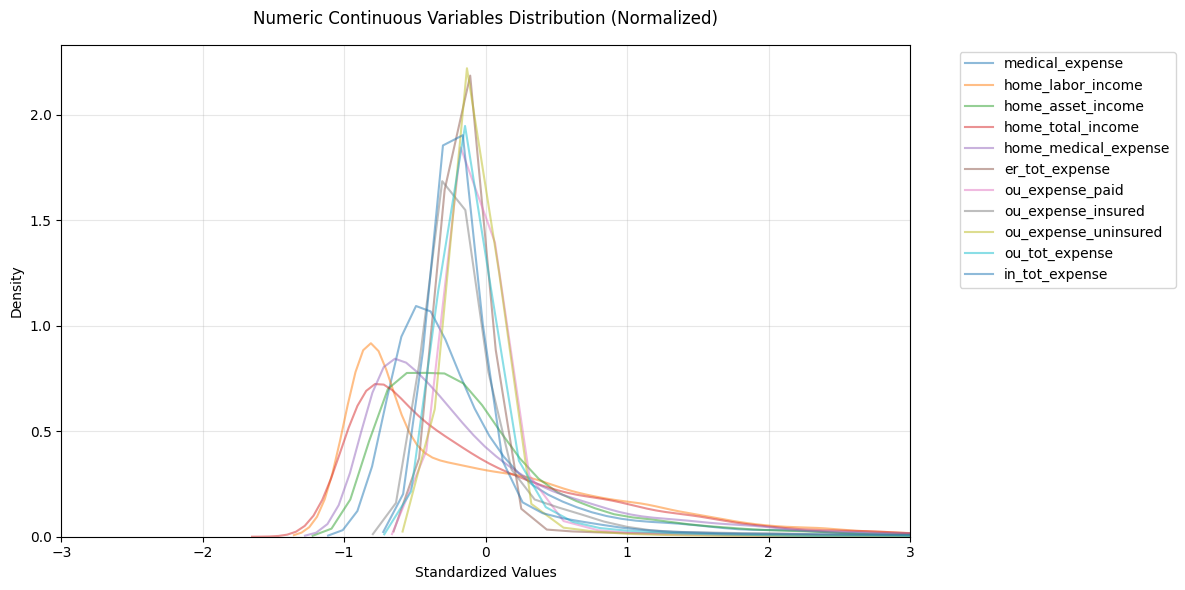

In [90]:
# 수치형 - 연속형 변수들 vs y 변수간의 분포 비교: scaled
# 정규화된 분포는 대체적으로 유사.
# 특히, in_tot_expense (입원 총 비용) > er_tot_expense (응급실 총 비용) > ou_expense_uninsured (본인 부담금 총 비용) 순으로 비용이 높음.
# 당연하게도, 전체 의료 비용과 각 의료 비용 간의 관계는 매우 유사할 수밖에 없음.
draw_kde_plot(df_final, numeric_continuous_cols)


## 3.1. 상관 분석

In [91]:
'''
연속형 X 변수와 연속형 Y 변수: 정규성 검증 -> Pearson 상관분석 (정규성 가정 만족 시) / Spearman 분석 (정규석 가정 만족 못할 시).

1. home_medical_expense (상관계수: 0.785, p-value < 0.05)
    - 가구 의료비용과 매우 강한 양의 상관관계를 보이며, 가구 의료비용이 증가할수록 개인 의료비용도 함께 증가하는 경향이 있음
    - 이는 가구 단위의 의료비용이 개인 의료비용의 주요 결정 요인임을 시사

2. in_tot_expense (상관계수: 0.422, p-value < 0.05)
    - 입원 총비용과 중간 정도의 양의 상관관계를 보이며, 입원 비용이 높을수록 개인 의료비용도 증가하는 경향이 있음
    - 이는 입원이 의료비용에 상당한 영향을 미치는 요인임을 시사
    
3. ou_tot_expense (상관계수: 0.408, p-value < 0.05)
    - 외래 총비용과 중간 정도의 양의 상관관계를 보이며, 외래 진료 비용이 높을수록 개인 의료비용도 증가하는 경향이 있음
    - 이는 외래 진료도 의료비용에 중요한 영향을 미치는 요인임을 시사

4. ou_expense_insured (상관계수: 0.382, p-value < 0.05)
    - 보험 적용 외래비용과 중간 정도의 양의 상관관계를 보이며, 보험 적용 비용이 높을수록 개인 의료비용도 증가하는 경향이 있음
    - 이는 보험 적용 비용이 의료비용에 상당한 영향을 미치는 요인임을 시사

5. ou_expense_paid (상관계수: 0.342, p-value < 0.05)
    - 본인부담 외래비용과 약한 양의 상관관계를 보이며, 본인부담 비용이 높을수록 개인 의료비용도 증가하는 경향이 있음
    - 이는 본인부담 비용이 의료비용에 일정한 영향을 미치는 요인임을 시사

6. er_tot_expense (상관계수: 0.200, p-value < 0.05), ou_expense_uninsured (상관계수: 0.220, p-value < 0.05)
    - 응급실 총비용과 비보험 외래비용은 약한 양의 상관관계를 보이며, 이는 개인 의료비용에 미치는 영향이 제한적임을 시사
    - 두 변수 모두 비슷한 수준의 상관관계를 보임

7. home_asset_income (상관계수: 0.118, p-value < 0.05)
    - 가구 자산소득은 매우 약한 양의 상관관계를 보이며, 이는 자산소득이 의료비용에 미치는 영향이 제한적임을 시사

8. home_labor_income (상관계수: -0.088, p-value < 0.05), home_total_income (상관계수: -0.032, p-value < 0.05)
    - 가구 노동소득과 총소득은 매우 약한 음의 상관관계를 보이며, 이는 소득이 의료비용에 미치는 영향이 제한적임을 시사
    - 특히 총소득은 거의 상관관계가 없다고 볼 수 있음
'''



continuous_correlation_test(df_final, numeric_continuous_cols, 'medical_expense')

,medical_expense,home_labor_income,home_asset_income,home_total_income,home_medical_expense,er_tot_expense,ou_expense_paid,ou_expense_insured,ou_expense_uninsured,ou_tot_expense,in_tot_expense
type,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous
test,spearman,spearman,spearman,spearman,spearman,spearman,spearman,spearman,spearman,spearman,spearman
correlation,1.0,-0.088254,0.117684,-0.032322,0.784619,0.199663,0.342393,0.382114,0.219767,0.408133,0.488587
p_value,0.0,0.0,0.0,0.003192,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
'''
범주형 - 순서형  변수와 의료비용 (수치형 - 연속형) 간의 Spearman 상관분석 결과 해석:

1. subjective_health (상관계수: 0.472, p-value < 0.05)
    - 주관적 건강상태와 중간 정도의 양의 상관관계를 보이며, 건강상태가 좋다고 인식할수록 의료비용이 증가하는 경향이 있음
    - 이는 건강에 대한 관심이 높은 사람들이 더 많은 의료비용을 지출할 가능성을 시사

2. frequency_intense_workout (상관계수: 0.458, p-value < 0.05)
    - 고강도 운동 빈도와 중간 정도의 양의 상관관계를 보이며, 고강도 운동을 자주 할수록 의료비용이 증가하는 경향이 있음
    - 이는 건강 관리에 적극적인 사람들이 더 많은 의료비용을 지출할 가능성을 시사

3. smoking (상관계수: 0.434, p-value < 0.05)
    - 흡연 상태와 중간 정도의 양의 상관관계를 보이며, 흡연이 의료비용에 상당한 영향을 미치는 것으로 나타남
    - 이는 흡연이 건강에 미치는 영향이 의료비용에 반영될 수 있음을 시사

4. frequency_mild_workout (상관계수: 0.359, p-value < 0.05), frequency_10m_walk (상관계수: 0.355, p-value < 0.05)
    - 중간 강도 운동과 10분 걷기 빈도는 약한 양의 상관관계를 보이며, 이는 운동이 의료비용에 일정한 영향을 미친다는 것을 시사
    - 두 변수 모두 비슷한 수준의 상관관계를 보임

5. education_level (상관계수: 0.349, p-value < 0.05), drinking (상관계수: 0.346, p-value < 0.05)
    - 교육수준과 음주 빈도는 약한 양의 상관관계를 보이며, 이는 이 변수들이 의료비용에 제한적인 영향을 미친다는 것을 시사
    - 두 변수 모두 비슷한 수준의 상관관계를 보임

6. has_disability (상관계수: -0.004, p-value > 0.05)
    - 장애 여부는 의료비용과 통계적으로 유의미한 상관관계를 보이지 않음
    - 이는 장애가 의료비용에 미치는 영향이 다른 요인들에 의해 조정될 수 있음을 시사
'''



# 함수 사용 예시
ordinal_results = ordinal_correlation_test(df_final, categorical_ordinal_cols, 'medical_expense')
ordinal_results

,education_level,smoking,drinking,frequency_intense_workout,frequency_mild_workout,frequency_10m_walk,subjective_health,has_disability
type,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal
test,spearman,spearman,spearman,spearman,spearman,spearman,spearman,spearman
correlation,0.348579,0.433727,0.345587,0.457578,0.358662,0.355442,0.471965,-0.004016
p_value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.714179


In [93]:
# 함수 사용 예시
nominal_results = nominal_anova_test(df_final, categorical_nominal_cols, 'medical_expense')
nominal_results

,visited_facility_this_year,intake_medication_this_year,followed_prescription,had_medication_side_effects,reason_no_intake_involuntary,reason_no_intake_unknown,reason_no_intake_voluntary,medication_satisfaction_dissatisfied,medication_satisfaction_satisfied,medication_satisfaction_unknown,...,reason_med_unavailability_lack_info,reason_med_unavailability_not_applicable,reason_med_unavailability_perceived_need_constraint,reason_med_unavailability_physical_time,reason_med_unavailability_unnecessary,in_is_public,in_reason_accident,in_reason_disease,in_reason_etc,in_reason_return
type,nominal,nominal,nominal,nominal,nominal,nominal,nominal,nominal,nominal,nominal,...,nominal,nominal,nominal,nominal,nominal,nominal,nominal,nominal,nominal,nominal
test,kruskal_wallis,kruskal_wallis,kruskal_wallis,kruskal_wallis,kruskal_wallis,kruskal_wallis,kruskal_wallis,kruskal_wallis,kruskal_wallis,kruskal_wallis,...,kruskal_wallis,kruskal_wallis,kruskal_wallis,kruskal_wallis,kruskal_wallis,kruskal_wallis,kruskal_wallis,kruskal_wallis,kruskal_wallis,kruskal_wallis
test_statistic,116.325994,120.954289,155.341138,125.170998,0.901978,119.264751,59.417431,36.461328,69.764571,63.290676,...,63.136807,80.90304,66.633503,65.668522,72.485263,622.708333,627.328579,630.022132,622.631796,634.612519
p_value,0.0,0.0,0.0,0.0,0.342252,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
is_normal,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
is_homogeneous,False,False,False,False,True,False,False,False,True,False,...,True,True,True,True,False,False,False,False,False,False


In [94]:
# 다중공성성 체크

# 1. VIF(Variance Inflation Factor) 계산


# def calculate_vif(X):
#     vif_data = pd.DataFrame()
#     vif_data["Variable"] = X.columns
#     vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#     return vif_data

# # VIF 계산
# vif_df = calculate_vif(df_final.drop(['HHIDWON', 'PIDWON', 'YEAR'], axis=1)[numeric_continuous_cols])
# print("VIF 값이 높은 변수들:")
# print(vif_df[vif_df["VIF"] > 10].sort_values("VIF", ascending=False))

# # 2. 상관관계가 높은 변수들 확인
# correlation_matrix = X_train_indexed.corr()
# high_corr_pairs = []
# for i in range(len(correlation_matrix.columns)):
#     for j in range(i):
#         if abs(correlation_matrix.iloc[i, j]) > 0.9:  # 상관계수 0.9 이상인 쌍
#             high_corr_pairs.append((
#                 correlation_matrix.columns[i],
#                 correlation_matrix.columns[j],
#                 correlation_matrix.iloc[i, j]
#             ))

# print("\n상관계수가 높은 변수 쌍:")
# for var1, var2, corr in high_corr_pairs:
#     print(f"{var1} - {var2}: {corr:.3f}")

# # 3. 문제가 되는 변수 제거 후 모델 적합
# # 예: VIF가 10보다 큰 변수들 제거
# high_vif_cols = vif_df[vif_df["VIF"] > 10]["Variable"].tolist()
# X_train_clean = X_train_indexed.drop(columns=high_vif_cols)

# # 4. 모델 적합
# fe_model = PanelOLS(y_train_indexed, X_train_clean, entity_effects=True)
# fe_results = fe_model.fit()
# print(fe_results.summary)

# 4. 모델링

## 4.1. Train-Test split

In [95]:
def train_test_split_by_year(df: pd.DataFrame, target_col: str = 'medical_expense') -> tuple:
    """
    연도 기반으로 train-test split을 수행하는 함수
    
    Parameters:
    -----------
    df : pandas.DataFrame
        입력 데이터프레임
    target_col : str
        타겟 변수명 (기본값: 'medical_expense')
    
    Returns:
    --------
    tuple
        (X_train, X_test, y_train, y_test)
    """
    # train 데이터 (2014-2017)
    train_data = move_y_column(df[df['YEAR'].isin([2014, 2015, 2016, 2017])].copy())
    
    # test 데이터 (2018)
    test_data = move_y_column(df[df['YEAR'] == 2018].copy()) 

    print(f"Train data years: {train_data['YEAR'].unique()}")
    print(f"Test data years: {test_data['YEAR'].unique()}")

    return train_data, test_data

def X_y_split_by_year(train: pd.DataFrame, test: pd.DataFrame, target_col: str = 'medical_expense', is_panel: bool = True) -> tuple:    
    # 타겟 변수 분리
    y_train = train[target_col].reset_index(drop=True)
    y_test = test[target_col].reset_index(drop=True)

    # 특성 변수 분리 (타겟 변수와 YEAR 제외)
    X_train = train.drop([target_col], axis=1).reset_index(drop=True)
    X_test = test.drop([target_col], axis=1).reset_index(drop=True)

    # 데이터 크기 출력
    print(f"Train data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    
    if not is_panel:
        X_train = X_train.drop(['HHIDWON', 'PIDWON', 'YEAR'], axis=1)
        X_test = X_test.drop(['HHIDWON', 'PIDWON', 'YEAR'], axis=1)

    return X_train, X_test, y_train, y_test

In [96]:
train, test = train_test_split_by_year(df_final)
train.head()

Train data years: [2014 2015 2016 2017]
Test data years: [2018]


,HHIDWON,PIDWON,YEAR,num_years_since_diagnosis,visited_facility_this_year,intake_medication_this_year,followed_prescription,had_medication_side_effects,reason_no_intake_involuntary,reason_no_intake_unknown,...,in_count,in_num,in_num_days,in_is_public,in_tot_expense,in_reason_accident,in_reason_disease,in_reason_etc,in_reason_return,medical_expense
0,10004,1000402,2014,5.0,0.0,0.0,-1.0,-1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,10067300.0
1,10004,1000402,2015,5.0,0.0,0.0,-1.0,-1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0.0
2,10004,1000402,2016,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,1,0,0,133000.0
3,10004,1000402,2017,2.0,0.0,0.0,-1.0,-1.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,209100.0
5,10006,1000601,2014,4.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,1,0,0,254750.0


In [97]:
X_train_panel, X_test_panel, y_train, y_test = X_y_split_by_year(train, test, 'medical_expense', is_panel = True)
X_train_panel.head()

Train data shape: (6656, 121)
Test data shape: (1664, 121)


,HHIDWON,PIDWON,YEAR,num_years_since_diagnosis,visited_facility_this_year,intake_medication_this_year,followed_prescription,had_medication_side_effects,reason_no_intake_involuntary,reason_no_intake_unknown,...,reason_med_unavailability_unnecessary,in_count,in_num,in_num_days,in_is_public,in_tot_expense,in_reason_accident,in_reason_disease,in_reason_etc,in_reason_return
0,10004,1000402,2014,5.0,0.0,0.0,-1.0,-1.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,10004,1000402,2015,5.0,0.0,0.0,-1.0,-1.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,10004,1000402,2016,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
3,10004,1000402,2017,2.0,0.0,0.0,-1.0,-1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,10006,1000601,2014,4.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0


In [98]:
X_train, X_test, y_train, y_test = X_y_split_by_year(train, test, 'medical_expense', is_panel = False)
X_train.head() 

Train data shape: (6656, 121)
Test data shape: (1664, 121)


,num_years_since_diagnosis,visited_facility_this_year,intake_medication_this_year,followed_prescription,had_medication_side_effects,reason_no_intake_involuntary,reason_no_intake_unknown,reason_no_intake_voluntary,medication_satisfaction_dissatisfied,medication_satisfaction_satisfied,...,reason_med_unavailability_unnecessary,in_count,in_num,in_num_days,in_is_public,in_tot_expense,in_reason_accident,in_reason_disease,in_reason_etc,in_reason_return
0,5.0,0.0,0.0,-1.0,-1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,5.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
3,2.0,0.0,0.0,-1.0,-1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,4.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0


## 4.2. Outlier Detection and Removal on Train Data

In [99]:
def remove_outliers_iqr(df, column='medical_expense', lower_bound=0.25, upper_bound=0.75, multiplier=1.5):
    """
    IQR 방법을 사용하여 이상치를 제거하는 함수
    
    Parameters:
    -----------
    df : pandas DataFrame
        입력 데이터프레임
    column : str
        이상치를 제거할 컬럼명 (기본값: 'TOT_EXP')
    lower_bound : float
        하위 사분위수 경계 (기본값: 0.25)
    upper_bound : float
        상위 사분위수 경계 (기본값: 0.75)
    multiplier : float
        IQR 곱셈 계수 (기본값: 1.5)
    
    Returns:
    --------
    tuple
        (이상치가 제거된 데이터프레임, 제거된 이상치의 개수, 이상치의 비율)
    """
    # 원본 데이터의 행 수 저장
    original_len = len(df)
    
    # 사분위수 계산
    Q1 = df[column].quantile(lower_bound)
    Q3 = df[column].quantile(upper_bound)
    IQR = Q3 - Q1
    
    # 이상치 경계 계산
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    # 이상치가 아닌 데이터만 선택
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    # 제거된 이상치의 개수와 비율 계산
    removed_count = original_len - len(df_cleaned)
    removed_ratio = removed_count / original_len
    
    # 결과 출력
    print(f"\n{column} 컬럼의 이상치 제거 결과:")
    print(f"Q1 (25%): {Q1:,.2f}")
    print(f"Q3 (75%): {Q3:,.2f}")
    print(f"IQR: {IQR:,.2f}")
    print(f"하위 경계: {lower_bound:,.2f}")
    print(f"상위 경계: {upper_bound:,.2f}")
    print(f"제거된 이상치 개수: {removed_count:,}개")
    print(f"제거된 이상치 비율: {removed_ratio:.2%}")
    
    # 이상치 제거 전후 분포 시각화
    plt.figure(figsize=(15, 5))
    
    # 원본 데이터 분포
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=column, bins=50)
    plt.axvline(x=lower_bound, color='r', linestyle='--', label='Lower Bound')
    plt.axvline(x=upper_bound, color='r', linestyle='--', label='Upper Bound')
    plt.title(f'Original {column} Distribution')
    plt.legend()
    
    # 이상치 제거 후 분포
    plt.subplot(1, 2, 2)
    sns.histplot(data=df_cleaned, x=column, bins=50)
    plt.title(f'Cleaned {column} Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # 박스플롯으로 비교
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, y=column)
    plt.title(f'Original {column} Boxplot')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_cleaned, y=column)
    plt.title(f'Cleaned {column} Boxplot')
    
    plt.tight_layout()
    plt.show()
    
    return df_cleaned, removed_count, removed_ratio

In [100]:
# train, removed_count, removed_ratio = remove_outliers_iqr(train, column='medical_expense')

# # 이상치 제거 전후 통계량 비교
# print("\n이상치 제거 전후 통계량 비교:")
# print("\n원본 데이터 통계량:")
# print(train['medical_expense'].describe())
# print("\n이상치 제거 후 통계량:")
# print(train['medical_expense'].describe())

## 4.3. Feature Selection: LASSO

Train data shape: (6656, 121)
Test data shape: (1664, 121)
LASSO Feature Selection Results:

Top 10 most important features:
                                               Feature    Coefficient  \
74                                 ou_reason_aesthetic  715074.445902   
85                           ou_treatment_type_surgery -642668.283440   
75                                       ou_reason_etc  566009.743331   
35                         type_medical_support_public -444931.573606   
78                         ou_treatment_type_dentistry  427897.115359   
53                                 housing_floor_below  380902.701688   
109                                           in_count  380157.193086   
108              reason_med_unavailability_unnecessary  379473.514485   
106  reason_med_unavailability_perceived_need_const... -375127.934993   
77                                       ou_reason_pre -347792.909685   

     Abs_Coefficient  
74     715074.445902  
85     642668.283440  
75

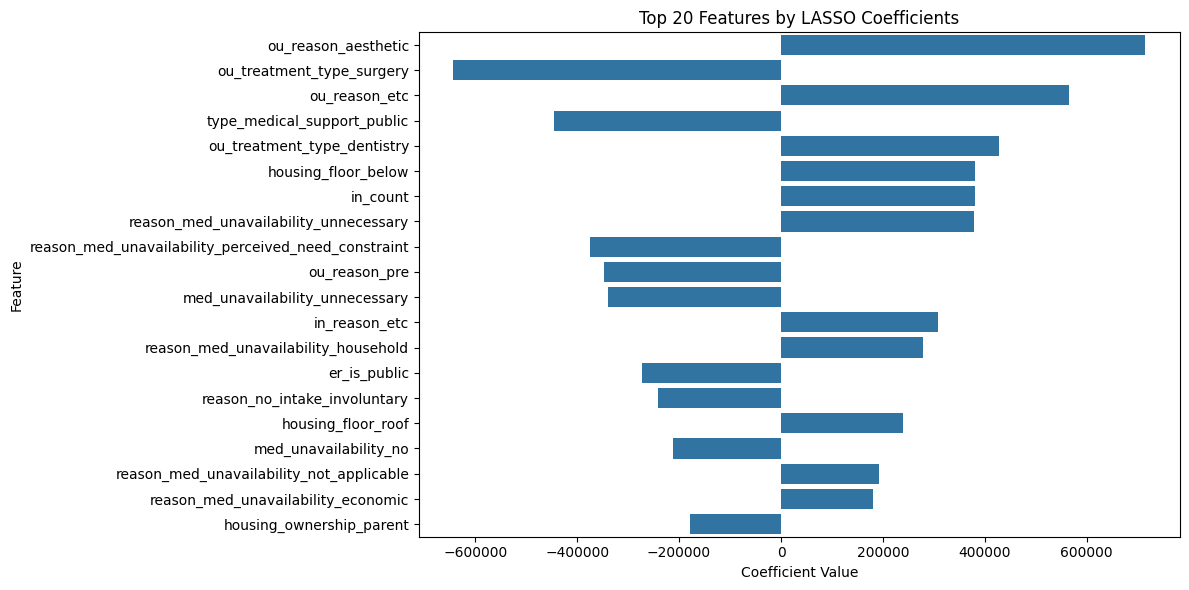


Features removed by LASSO (coefficient = 0):
Number of removed features: 3
['ou_num', 'in_num', 'pension_receipt_status_unknown']


In [101]:
X_train, X_test, y_train, y_test = X_y_split_by_year(train, test, 'medical_expense', is_panel = False)

# LASSO 모델 학습
lasso = Lasso(alpha=0.01)  # alpha 값은 조정 가능
lasso.fit(X_train, y_train)

# 특성 중요도 계산
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso.coef_
})

# 계수 절대값 기준으로 정렬
feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

# 결과 출력
print("LASSO Feature Selection Results:")
print("\nTop 10 most important features:")
print(feature_importance.head(10))

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(20), 
            x='Coefficient', 
            y='Feature')
plt.title('Top 20 Features by LASSO Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 제거된 특성 확인 (계수가 0인 특성)
zero_features = feature_importance[feature_importance['Coefficient'] == 0]
print("\nFeatures removed by LASSO (coefficient = 0):")
print(f"Number of removed features: {len(zero_features)}")
print(zero_features['Feature'].tolist())

In [102]:
# X_train = X_train.drop(zero_features['Feature'].tolist(), axis=1)
# X_test = X_test.drop(zero_features['Feature'].tolist(), axis=1)
# X_train.head()

## 4.3. Baseline Models

### 4.3.0. Linear Regression


In [103]:
# Linear Regression 모델 초기화
lr = LinearRegression()

# 모델 학습
lr.fit(X_train, y_train)

LinearRegression()

### 4.3.1. Linear Model via Hausman Test

- $H_0$ = 변동효과 모형 선정
- $H_\alpha$ = 고정효과 모형 선정

In [104]:
# 1. MultiIndex 설정
train_indexed = train.set_index(['PIDWON', 'YEAR']).drop(columns=['HHIDWON', 'ou_count', 'in_count'])
test_indexed = test.set_index(['PIDWON', 'YEAR']).drop(columns=['HHIDWON', 'ou_count', 'in_count'])

# 2. X와 y 분리
X_train_indexed = train_indexed.drop('medical_expense', axis=1)
y_train_indexed = train_indexed['medical_expense']
X_test_indexed = test_indexed.drop('medical_expense', axis=1)
y_test_indexed = test_indexed['medical_expense']

# X_train_indexed


In [105]:
# y_train_indexed

In [106]:
# 1. 모든 수치형으로 강제 변환
X_train_indexed = X_train_indexed.astype(float)
X_test_indexed = X_test_indexed.astype(float)

# 2. 상수값 컬럼 제거
cols_to_drop = X_train_indexed.columns[X_train_indexed.nunique() <= 1]
X_train_indexed = X_train_indexed.drop(columns=cols_to_drop)
X_test_indexed = X_test_indexed.drop(columns=cols_to_drop)

# 3. 더미 변수 trap 회피용 첫 dummy 제거
X_train_indexed = pd.get_dummies(X_train_indexed, drop_first=True)
X_test_indexed = pd.get_dummies(X_test_indexed, drop_first=True)

# 4. 다시 고정효과 모형 적합
fe_model = PanelOLS(y_train_indexed, X_train_indexed, entity_effects=True,
                    check_rank=False, drop_absorbed=True)
fe_results = fe_model.fit()
print(fe_results.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:        medical_expense   R-squared:                        0.6289
Estimator:                   PanelOLS   R-squared (Between):              0.7146
No. Observations:                6656   R-squared (Within):               0.6289
Date:                Wed, May 28 2025   R-squared (Overall):              0.6689
Time:                        17:23:17   Log-likelihood                    -1e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      562.31
Entities:                        1664   P-value                           0.0000
Avg Obs:                       4.0000   Distribution:                 F(15,4977)
Min Obs:                       4.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             1158.0
                            

In [107]:
# # 3. 변동 효과 모형 적합
# 무작위 효과 모델 적합
# 불필요한 인자 제거
re_model = RandomEffects(y_train_indexed, X_train_indexed, check_rank=False)

# 모델 학습
re_results = re_model.fit()

# 결과 출력
print(re_results.summary)


                        RandomEffects Estimation Summary                        
Dep. Variable:        medical_expense   R-squared:                        0.7093
Estimator:              RandomEffects   R-squared (Between):              0.7794
No. Observations:                6656   R-squared (Within):               0.6753
Date:                Wed, May 28 2025   R-squared (Overall):              0.7239
Time:                        17:23:17   Log-likelihood                -1.006e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      140.03
Entities:                        1664   P-value                           0.0000
Avg Obs:                       4.0000   Distribution:                F(114,6541)
Min Obs:                       4.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             114.14
                            

In [108]:
from scipy import stats
import numpy as np

# 1. 공통 파라미터만 비교
common_params = fe_results.params.index.intersection(re_results.params.index)

# 2. 차이 및 공분산 계산
coef_diff = fe_results.params[common_params] - re_results.params[common_params]
cov_diff = fe_results.cov.loc[common_params, common_params] - re_results.cov.loc[common_params, common_params]

# 3. 통계량 계산
hausman_stat = coef_diff.T @ np.linalg.pinv(cov_diff) @ coef_diff
df = len(coef_diff)
hausman_pval = 1 - stats.chi2.cdf(hausman_stat, df)

# 4. 출력
print(f"\nHausman 검정 결과:")
print(f"통계량: {hausman_stat:.4f}")
print(f"p-value: {hausman_pval:.4f}")

if hausman_pval < 0.05:
    print("\n❗ 고정효과 모형을 선택해야 합니다 (p-value < 0.05)")
else:
    print("\n✅ 무작위효과 모형을 선택할 수 있습니다 (p-value >= 0.05)")


Hausman 검정 결과:
통계량: 54.3347
p-value: 0.0000

❗ 고정효과 모형을 선택해야 합니다 (p-value < 0.05)


### 4.3.2 Boosting

In [109]:
xgb = XGBRegressor(
        n_estimators=100,  # 트리 개수 (예시)
        learning_rate=0.1,
        random_state=42    # 재현성
    )
xgb.fit(X_train, y_train)

# LightGBM
lgb = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
lgb.fit(X_train, y_train)

# CatBoost
cat = CatBoostRegressor(
    iterations=100,
    learning_rate=0.1,
    random_state=42,
    verbose=False  # 학습 진행 상황 출력 끄기
)
cat.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3430
[LightGBM] [Info] Number of data points in the train set: 6656, number of used features: 115
[LightGBM] [Info] Start training from score 1093346.188101


### 4.3.3 Bagging (Random Forest)

In [110]:
from sklearn.ensemble import RandomForestRegressor
# Random Forest 모델 학습
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### 4.3.4. DL (TabNet)

In [111]:
# # TabNet 모델 초기화
# tabnet = TabNetRegressor(
#     n_d=8,                # 의사결정 단계 수
#     n_a=8,                # 주의 메커니즘의 크기
#     n_steps=3,            # 반복 단계 수
#     gamma=1.3,            # 특성 재사용 계수
#     n_independent=2,      # 독립적인 GLU 레이어 수
#     n_shared=2,           # 공유 GLU 레이어 수
#     lambda_sparse=1e-3,   # 희소성 정규화 계수
#     optimizer_fn=torch.optim.Adam,
#     optimizer_params=dict(lr=2e-2),
#     scheduler_params=dict(
#         mode="min",
#         patience=5,
#         min_lr=1e-5,
#         factor=0.9
#     ),
#     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
#     mask_type="entmax",   # 특성 선택 메커니즘
#     verbose=10
# )

# # 데이터를 numpy 배열로 변환
# X_train_np = X_train.astype('float32').values
# X_test_np = X_test.astype('float32').values
# y_train_np = y_train.astype('float32').values.reshape(-1, 1)
# y_test_np = y_test.astype('float32').values.reshape(-1, 1)

# # 모델 학습
# tabnet.fit(
#     X_train=X_train_np,
#     y_train=y_train_np,
#     eval_set=[(X_test_np, y_test_np)],
#     eval_name=['test'],
#     eval_metric=['rmse'],
#     max_epochs=50,
#     patience=20,
#     batch_size=10,
#     virtual_batch_size=5,
#     num_workers=0,
#     drop_last=False
# )


# 5. 성능 평가

In [112]:
used_cols = fe_results.model.exog.vars # 모델 학습 시 실제 사용된 변수들만 추출
X_test_aligned = X_test_indexed[used_cols] # 테스트 데이터에 동일한 컬럼 적용
fe_pred = fe_results.predict(X_test_aligned).squeeze()


Fixed Effects 모델 성능 평가:
RMSE: 1,037,901.0
MAE: 593,434.2
Adjusted R2 Score: 0.593

Linear Regression 모델 성능 평가:
RMSE: 999,245.2
MAE: 600,696.2
Adjusted R2 Score: 0.622

XGBoost 모델 성능 평가:
RMSE: 874,774.1
MAE: 434,944.7
Adjusted R2 Score: 0.710

LightGBM 모델 성능 평가:
RMSE: 883,257.6
MAE: 451,072.9
Adjusted R2 Score: 0.705

CatBoost 모델 성능 평가:
RMSE: 867,174.0
MAE: 472,214.4
Adjusted R2 Score: 0.715

Random Forest 모델 성능 평가:
RMSE: 856,267.9
MAE: 428,459.7
Adjusted R2 Score: 0.723


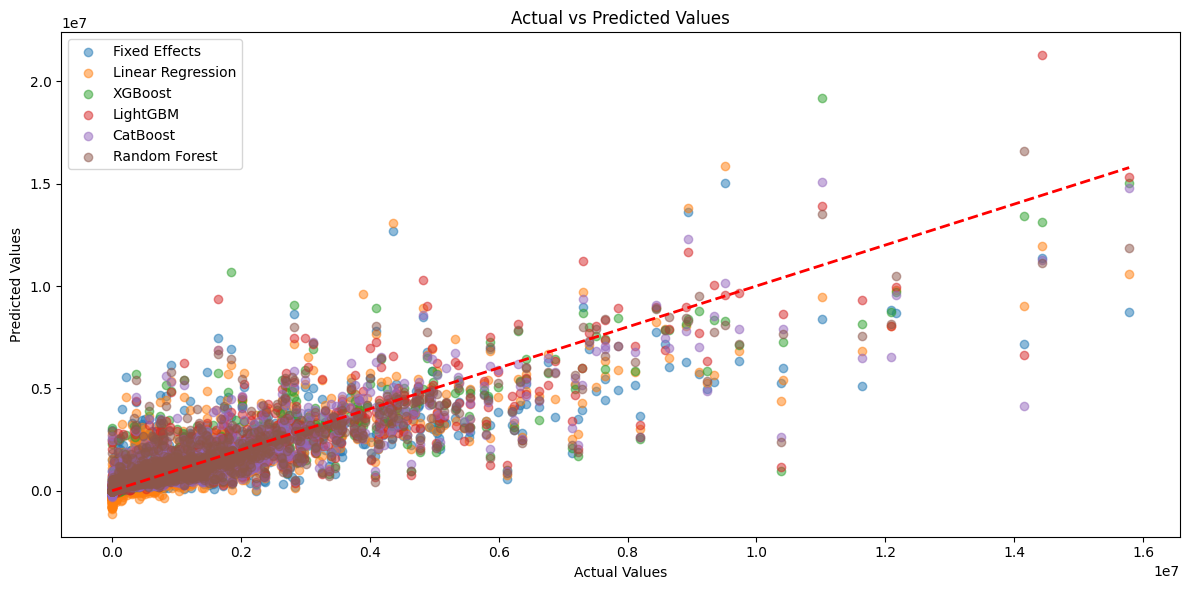

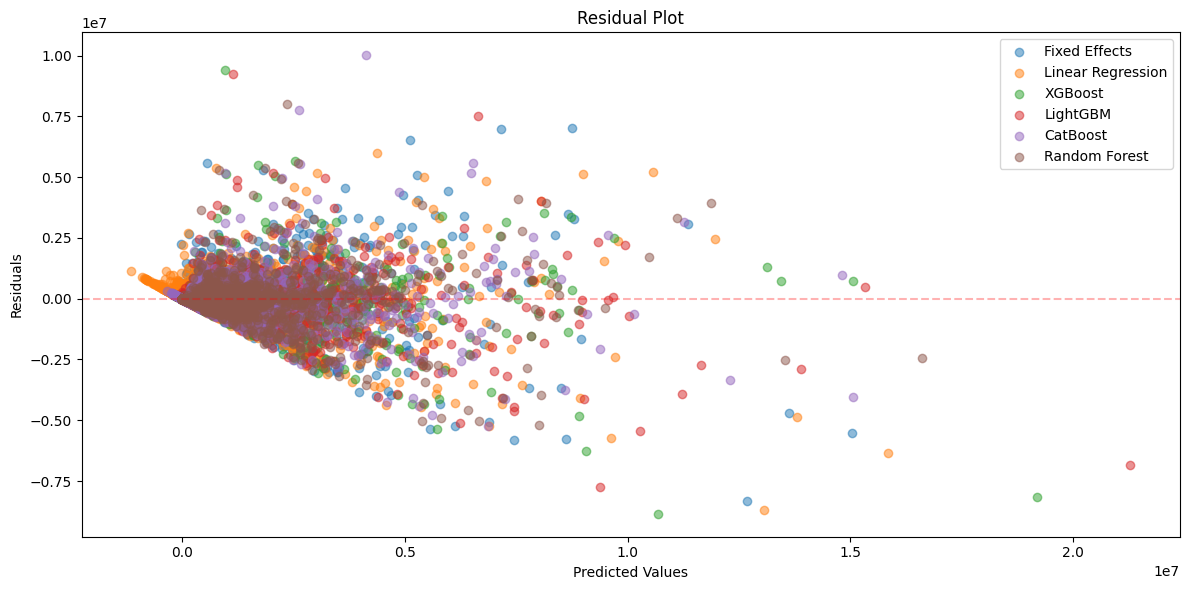

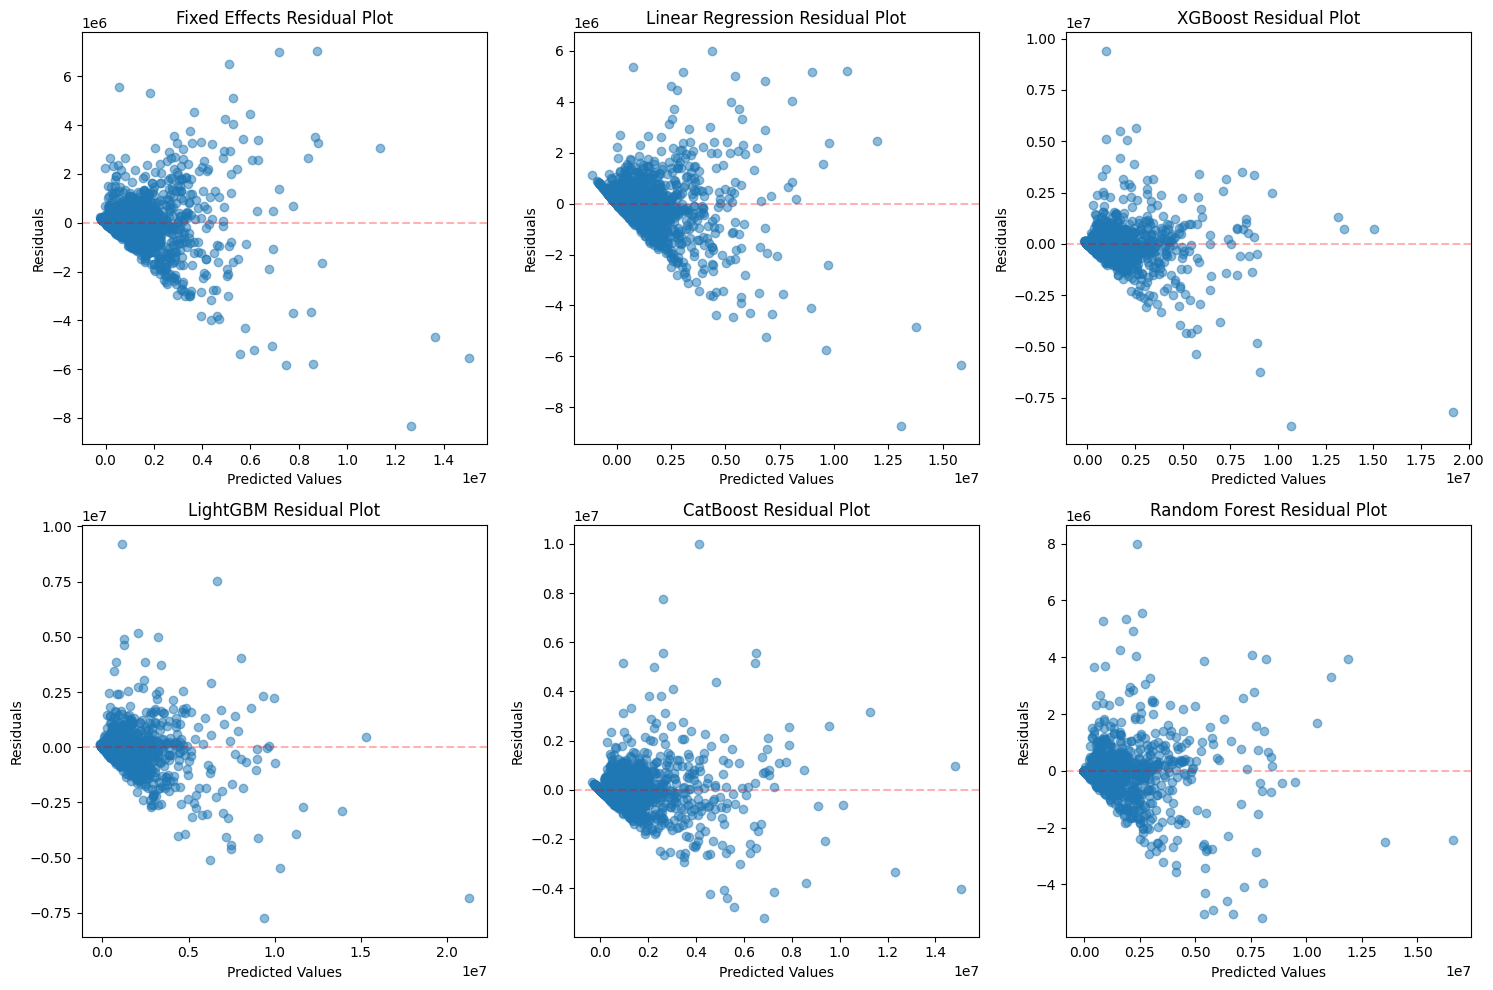

In [113]:
# 예측 수행
# fe_pred = fe_results.predict(X_test_indexed).squeeze()
lr_pred = lr.predict(X_test)
xgb_pred = xgb.predict(X_test)
lgb_pred = lgb.predict(X_test)
cat_pred = cat.predict(X_test)
rf_pred = rf.predict(X_test)

# Adjusted R² 계산 함수
def calculate_adjusted_r2(r2, n, p):
    """
    n: 샘플 수
    p: 특성 수
    """
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# 성능 평가를 위한 함수
def evaluate_model(y_true, y_pred, model_name, X_test):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Adjusted R² 계산
    n = len(y_true)  # 샘플 수
    p = X_test.shape[1]  # 특성 수
    adj_r2 = calculate_adjusted_r2(r2, n, p)
    
    print(f"\n{model_name} 모델 성능 평가:")
    # print(f"MSE: {mse:,.1f}")
    print(f"RMSE: {rmse:,.1f}")
    print(f"MAE: {mae:,.1f}")
    # print(f"R2 Score: {r2:.3f}")
    print(f"Adjusted R2 Score: {adj_r2:.3f}")
    
    return mse, rmse, mae, r2, adj_r2

# 각 모델의 성능 평가
fe_metrics = evaluate_model(y_test_indexed.squeeze(), fe_pred, "Fixed Effects", X_test_indexed)
lr_metrics = evaluate_model(y_test, lr_pred, "Linear Regression", X_test)
xgb_metrics = evaluate_model(y_test, xgb_pred, "XGBoost", X_test)
lgb_metrics = evaluate_model(y_test, lgb_pred, "LightGBM", X_test)
cat_metrics = evaluate_model(y_test, cat_pred, "CatBoost", X_test)
rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest", X_test)

# 결과 비교를 위한 시각화
metrics_df = pd.DataFrame({
    'Model': ['Fixed Effects','Linear Regression','XGBoost', 'LightGBM', 'CatBoost', 'Random Forest'],
    'RMSE': [fe_metrics[1], lr_metrics[1], xgb_metrics[1], lgb_metrics[1], cat_metrics[1], rf_metrics[1]],
    'MAE': [fe_metrics[2], lr_metrics[2], xgb_metrics[2], lgb_metrics[2], cat_metrics[2], rf_metrics[2]],
    # 'R2': [lr_metrics[3], xgb_metrics[3], lgb_metrics[3], cat_metrics[3], rf_metrics[3]],
    'Adjusted R2': [fe_metrics[4], lr_metrics[4], xgb_metrics[4], lgb_metrics[4], cat_metrics[4], rf_metrics[4]]
})

# 예측값과 실제값 비교 시각화
plt.figure(figsize=(12, 6))
plt.scatter(y_test_indexed, fe_pred, alpha=0.5, label='Fixed Effects')
plt.scatter(y_test, lr_pred, alpha=0.5, label='Linear Regression')
plt.scatter(y_test, xgb_pred, alpha=0.5, label='XGBoost')
plt.scatter(y_test, lgb_pred, alpha=0.5, label='LightGBM')
plt.scatter(y_test, cat_pred, alpha=0.5, label='CatBoost')
plt.scatter(y_test, rf_pred, alpha=0.5, label='Random Forest')
# plt.scatter(y_test, tabnet_pred, alpha=0.5, label='TabNet')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.tight_layout()
plt.show()

# Residual plot 추가
plt.figure(figsize=(12, 6))
plt.scatter(fe_pred, y_test_indexed - fe_pred, alpha=0.5, label='Fixed Effects')
plt.scatter(lr_pred, y_test - lr_pred, alpha=0.5, label='Linear Regression')
plt.scatter(xgb_pred, y_test - xgb_pred, alpha=0.5, label='XGBoost')
plt.scatter(lgb_pred, y_test - lgb_pred, alpha=0.5, label='LightGBM')
plt.scatter(cat_pred, y_test - cat_pred, alpha=0.5, label='CatBoost')
plt.scatter(rf_pred, y_test - rf_pred, alpha=0.5, label='Random Forest')

# y=0 기준선 추가
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)

plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.tight_layout()
plt.show()

# 각 모델별 개별 residual plot
models = {
    'Fixed Effects': (fe_pred, y_test_indexed.squeeze()),
    'Linear Regression': (lr_pred, y_test),
    'XGBoost': (xgb_pred, y_test),
    'LightGBM': (lgb_pred, y_test),
    'CatBoost': (cat_pred, y_test),
    'Random Forest': (rf_pred, y_test)
}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (model_name, (pred, true)) in enumerate(models.items()):
    residuals = true - pred
    axes[idx].scatter(pred, residuals, alpha=0.5)
    axes[idx].axhline(y=0, color='r', linestyle='--', alpha=0.3)
    axes[idx].set_xlabel('Predicted Values')
    axes[idx].set_ylabel('Residuals')
    axes[idx].set_title(f'{model_name} Residual Plot')

plt.tight_layout()
plt.show()

# 6. 성능 개선

In [114]:
# # Grid Search를 위한 파라미터 후보들
# param_grid = {
#     'n_estimators': [100, 200, 300],  # 트리의 개수
#     'max_depth': [None, 10, 20, 30],  # 트리의 최대 깊이
#     'min_samples_split': [2, 5, 10],  # 노드를 분할하기 위한 최소 샘플 수
#     'min_samples_leaf': [1, 2, 4],    # 리프 노드에 필요한 최소 샘플 수
#     'max_features': ['sqrt', 'log2'],  # 각 분할에서 고려할 특성의 수
#     'bootstrap': [True, False]         # 부트스트랩 샘플링 사용 여부
# }

# # Random Forest 모델 초기화
# rf = RandomForestRegressor(random_state=42)

# # GridSearchCV 설정
# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     cv=5,                # 5-fold 교차 검증
#     scoring='r2',        # 평가 지표
#     n_jobs=-1,          # 모든 CPU 코어 사용
#     verbose=2           # 진행 상황 출력
# )

# # Grid Search 실행
# print("Grid Search 시작...")
# grid_search.fit(X_train, y_train)

# # 최적의 파라미터와 성능 출력
# print("\n최적의 파라미터:", grid_search.best_params_)
# print("최적의 R2 점수:", grid_search.best_score_)

# # 최적의 모델로 예측
# best_rf = grid_search.best_estimator_
# y_pred = best_rf.predict(X_test)

# # 최적 모델의 성능 평가
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# n = len(y_test)
# p = X_test.shape[1]
# adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# print("\n최적 모델의 성능 평가:")
# print(f"MSE: {mse:,.1f}")
# print(f"RMSE: {rmse:,.1f}")
# print(f"MAE: {mae:,.1f}")
# print(f"R2 Score: {r2:.3f}")
# print(f"Adjusted R2 Score: {adj_r2:.3f}")

# 7. 결과 해석